In [1]:
from IPython.display import display, Math, Latex

def disp(ex):
    display(Math(latex(ex)))

def displ(tex):
    display(Math(tex))

In [2]:
def GenerateMatrix(equsys, vars):
    A=matrix(SR, [[(equ.lhs() - equ.rhs()).coefficient(v) for v in vars] for equ in equsys])
    return A

In [3]:
def GenerateSympyMatrix(equsys, vars):
    import sympy as sp
    A=sp.Matrix([[(equ.lhs() - equ.rhs()).coefficient(v) for v in vars] for equ in equsys])
    return A

In [4]:
class tayorOperator():
    def __init__(self, f, d):
        self.fd = diff(f, d)
        self.d = d
        self.m = d

    def do(self, taylor_op):
        self.fd = taylor_op.fd.diff(self.d)
        self.m *= taylor_op.m
        
    def subs(self, eq):
        return self.fd.subs(eq)

In [5]:
colors = ["red", "green", "yellow", "blue"]

In [97]:
# ZnO   a = 3.25 c = 5.2   Wurtzite (HCP)
# ZnO   4.580    Halite (FCC)

L = 0.458 # nm
L = 1.0 # nm

l = var("l") # 0.458 # nm
assume(l, "real")
assume(l > 0)

k = var("k") # 10000
assume(k, "real")
assume(k > 0)

omega = var("omega")

alpha = var("alpha") # 5000
assume(alpha, "real")
assume(alpha > 0)

beta = var("beta")   # 5000
assume(beta, "real")
assume(beta > 0)

m = var("m")
M = var("M")
t = var("t")
assume(t, "real")

values = [
    M == 65.38,
    m == 15.999,
    k == 1.0,
    l == L,
]

tmax = 12

class Lagrange():

    def __init__(self, rows, cols):
        self.data = []
        self.rows = rows
        self.cols = cols
        self.atom_count = self.rows * self.cols

        self.x = []
        self.y = []
        
        self.dx = []
        self.dy = []
        
        self.X = []
        self.Y = []
        
        self.DX = []
        self.DY = []
        
        self.vx = []
        self.vy = []
        
        self.Vx = []
        self.Vy = []
        
        self.Ax = []
        self.Ay = []
        
        self.x1 = []
        self.y1 = []

        for i in range(self.atom_count):

            exec(preparse("self.X_" + str(i) + " = var(\"x_" + str(i) + "\""")"))
            exec(preparse("self.Y_" + str(i) + " = var(\"y_" + str(i) + "\""")"))

            exec(preparse("self.DX_" + str(i) + " = var(\"dx_" + str(i) + "\""")"))
            exec(preparse("self.DY_" + str(i) + " = var(\"dy_" + str(i) + "\""")"))

            exec(preparse("self.Vx_" + str(i) + " = var(\"vx_" + str(i) + "\""")"))
            exec(preparse("self.Vy_" + str(i) + " = var(\"vy_" + str(i) + "\""")"))

            exec(preparse("self.x_" + str(i) + " = function(\"x_" + str(i) + "\""")(t)"))
            exec(preparse("self.y_" + str(i) + " = function(\"y_" + str(i) + "\""")(t)"))

            exec(preparse("self.dx_" + str(i) + " = function(\"dx_" + str(i) + "\""")(t)"))
            exec(preparse("self.dy_" + str(i) + " = function(\"dy_" + str(i) + "\""")(t)"))

            exec(preparse("self.vx_" + str(i) + " = function(\"vx_" + str(i) + "\""")(t)"))
            exec(preparse("self.vy_" + str(i) + " = function(\"vy_" + str(i) + "\""")(t)"))

            exec(preparse("self.x += [self.x_" + str(i) + "]"))
            exec(preparse("self.y += [self.y_" + str(i) + "]"))

            exec(preparse("self.dx += [self.dx_" + str(i) + "]"))
            exec(preparse("self.dy += [self.dy_" + str(i) + "]"))

            exec(preparse("self.X += [self.X_" + str(i) + "]"))
            exec(preparse("self.Y += [self.Y_" + str(i) + "]"))

            exec(preparse("self.DX += [self.DX_" + str(i) + "]"))
            exec(preparse("self.DY += [self.DY_" + str(i) + "]"))

            exec(preparse("self.vx += [self.vx_" + str(i) + "]"))
            exec(preparse("self.vy += [self.vy_" + str(i) + "]"))

            exec(preparse("self.Vx += [self.Vx_" + str(i) + "]"))
            exec(preparse("self.Vy += [self.Vy_" + str(i) + "]"))

            exec(preparse("Ax_" + str(i) + " = var(\"A_x_" + str(i) + "\""")"))
            exec(preparse("Ay_" + str(i) + " = var(\"A_y_" + str(i) + "\""")"))

            exec(preparse("self.Ax += [A_x_"     + str(i) + "]"))
            exec(preparse("self.Ay += [A_y_"     + str(i) + "]"))

            exec(preparse("x1_" + str(i) + " = function(\"x1_" + str(i) + "\""")(t)"))
            exec(preparse("y1_" + str(i) + " = function(\"y1_" + str(i) + "\""")(t)"))
            
            exec(preparse("self.x1 += [x1_"     + str(i) + "]"))
            exec(preparse("self.y1 += [y1_"     + str(i) + "]"))        

        self.vel = []; # [1.0e+3 m/s]
        self.acc = []; # [1.0e+12 m/s^2]

        self.mass = []; # [kg/mol]

        self.f = [];
        self.w = [];# workaround for bond's potential energy


        self.crd0 = [];
        self.crd  = [];
        self.dcrd = [];
        self.rc   = [];
        self.nbr  = [];
        self.nbri = [];

        self.step_counter = 0;

        self.sum_of_masses = 0.0; # [kg/mol]

        self.switch_xy = False

        counter = 0

        for row in range(self.rows):
            y0 = (row//4)*3*l
            if (row%4) == 0:
                y = 0 + y0
                x0 = 0
            elif (row%4) == 1:
                y = l/2 + y0
                x0 = l * (1/2*sqrt(3))
            elif (row%4) == 2:
                y = 3*l/2 + y0
                x0 = l * (1/2*sqrt(3))
            elif (row%4) == 3:
                y = 2*l + y0
                x0 = 0

            for col in range(self.cols):
                # self.mass += [65.38 if row%2 == 0 else 15.999]
                # self.mass[counter] *= 1.6605402e-27 * 6.0221367e+23;
                self.mass += [M if row%2 == 0 else m]

                self.sum_of_masses += self.mass[counter];# kg/mol ; all atoms

                x = x0 + col * l * sqrt(3)

                self.rc.append([row, col])
                #self.crd.append([self.X[counter]+self.Ax[counter]*exp(I*omega*t), \
                #                 -self.Y[counter]-self.Ay[counter]*exp(I*omega*t)])
                self.crd.append([x+self.Ax[counter]*exp(I*omega*t), \
                                 -y-self.Ay[counter]*exp(I*omega*t)])
                self.dcrd.append([self.DX[counter], -self.DY[counter]])
                self.crd0.append([x, -y])

                #print(row, col, counter, x, y)

                self.vel.append([self.dx[counter].diff(t), -self.dy[counter].diff(t)]);
                self.acc.append([self.dx[counter].diff(t,2), -self.dy[counter].diff(t,2)]);

                self.f.append([0.0, 0.0]);
                self.w.append(0.0);

                if (row%4) == 0:
                    nb1 = (row - 1, col)
                    nb2 = (row + 1, col)
                    nb3 = (row + 1, col - 1)
                elif (row%4) == 1:
                    nb1 = (row - 1, col)
                    nb2 = (row - 1, col + 1)
                    nb3 = (row + 1, col)
                elif (row%4) == 2:
                    nb1 = (row - 1, col)
                    nb2 = (row + 1, col)
                    nb3 = (row + 1, col + 1)
                elif (row%4) == 3:
                    nb1 = (row - 1, col - 1)
                    nb2 = (row - 1, col)
                    nb3 = (row + 1, col)

                self.nbr.append([nb1, nb2, nb3])
                self.nbri.append([self.nbr2index(nb1), self.nbr2index(nb2), self.nbr2index(nb3)])

                counter+=1;

    def nbr2index(self, nb):
        r = nb[0]
        c = nb[1]
        return self.rc2index(r, c)

    def rc2index(self, r, c):

        if r < 0: r = self.rows - 1
        if c < 0: c = self.cols - 1
        if r == self.rows: r = 0
        if c == self.cols: c = 0

        index = self.cols * r + c

        return index

    def get_zink_crd(self):
        if self.switch_xy:
            return [[self.crd[self.rc2index(r, c)][1], \
                     self.crd[self.rc2index(r, c)][0]] \
                    for r in range(self.rows) \
                    for c in range(self.cols) if r%2 == 0 ]
        return [self.crd[self.rc2index(r, c)] \
                for r in range(self.rows) \
                for c in range(self.cols) if r%2 == 0 ]

    def get_zink_crd0(self):
        if self.switch_xy:
            return [[self.crd0[self.rc2index(r, c)][1], \
                     self.crd0[self.rc2index(r, c)][0]] \
                    for r in range(self.rows) \
                    for c in range(self.cols) if r%2 == 0 ]
        return [self.crd0[self.rc2index(r, c)] \
                for r in range(self.rows) \
                for c in range(self.cols) if r%2 == 0 ]

    def get_oxigen_crd(self):
        if self.switch_xy:
            return [[self.crd[self.rc2index(r, c)][1], \
                     self.crd[self.rc2index(r, c)][0]] \
                    for r in range(self.rows) \
                    for c in range(self.cols) if r%2 == 1 ]
        return [self.crd[self.rc2index(r, c)] \
                for r in range(self.rows) \
                for c in range(self.cols) if r%2 == 1 ]

    def get_oxigen_crd0(self):
        if self.switch_xy:
            return [[self.crd0[self.rc2index(r, c)][1], \
                     self.crd0[self.rc2index(r, c)][0]] \
                    for r in range(self.rows) \
                    for c in range(self.cols) if r%2 == 1 ]
        return [self.crd0[self.rc2index(r, c)] \
                for r in range(self.rows) \
                for c in range(self.cols) if r%2 == 1 ]

    def box_x(self):
        return self.cols * l * sqrt(3)

    def box_y(self):
        return (self.rows//4) * 3 * l

    def distance_x(self, i1, i2):
        distance0 = self.crd0[i2][0] - self.crd0[i1][0]
        distance = self.crd[i2][0] - self.crd[i1][0]
        if distance0 > self.box_x() / 2:
            return distance - self.box_x()
        if distance0 < - self.box_x() / 2:
            return distance + self.box_x()
        return distance

    def distance_x0(self, i1, i2):
        distance0 = self.crd0[i2][0] - self.crd0[i1][0]
        if distance0 > self.box_x() / 2:
            return distance0 - self.box_x()
        if distance0 < - self.box_x() / 2:
            return distance0 + self.box_x()
        return distance0

    def distance_dx(self, i1, i2):
        distance0 = self.crd0[i2][0] - self.crd0[i1][0]
        # distance = (self.crd[i2][0]) - (self.crd[i1][0])
        distance = (self.crd0[i2][0] + self.dcrd[i2][0]) \
                 - (self.crd0[i1][0] + self.dcrd[i1][0])
        if distance0 > self.box_x() / 2:
            return distance - self.box_x()
        if distance0 < - self.box_x() / 2:
            return distance + self.box_x()
        return distance

    def distance_y(self, i1, i2):
        distance0 = self.crd0[i2][1] - self.crd0[i1][1]
        distance = self.crd[i2][1] - self.crd[i1][1]
        if distance0 > self.box_y() / 2:
            return distance - self.box_y()
        if distance0 < - self.box_y() / 2:
            return distance + self.box_y()
        return distance

    def distance_y0(self, i1, i2):
        distance0 = self.crd0[i2][1] - self.crd0[i1][1]
        if distance0 > self.box_y() / 2:
            return distance0 - self.box_y()
        if distance0 < - self.box_y() / 2:
            return distance0 + self.box_y()
        return distance0
    
    def distance_dy(self, i1, i2):
        distance0 = self.crd0[i2][1] - self.crd0[i1][1]
        # distance = (self.crd[i2][1]) - (self.crd[i1][1])
        distance = (self.crd0[i2][1] + self.dcrd[i2][1]) \
                 - (self.crd0[i1][1] + self.dcrd[i1][1])
        if distance0 > self.box_y() / 2:
            return distance - self.box_y()
        if distance0 < - self.box_y() / 2:
            return distance + self.box_y()
        return distance

    def distance(self, i1, i2):
        return sqrt(self.distance_x(i1, i2)**2 + self.distance_y(i1, i2)**2)

    def distance_0(self, i1, i2):
        return sqrt(self.distance_x0(i1, i2)**2 + self.distance_y0(i1, i2)**2)

    def distance_d(self, i1, i2):
        return sqrt(self.distance_dx(i1, i2)**2 + self.distance_dy(i1, i2)**2)

    def calc_atom(self, i, use_dxdy=True, use_d0=False):
        #print("calc_atom", i)
        w = 0.0

        for nbr in self.nbri[i]:
            #print("nbr", nbr)
            if use_dxdy:
                if use_d0:
                    d  = self.distance_0  (i, nbr)
                else:
                    d  = self.distance_d  (i, nbr)
            else:
                if use_d0:
                    d  = self.distance_0  (i, nbr)
                else:
                    d  = self.distance  (i, nbr)
    
            #print("d", d)

            dl = d - l

            #print("dl", dl)

            f = k * dl # + alpha * dl**2 + beta * dl**3

            # bond's potential energy
            dw = k * dl * dl / 2 # + alpha * dl**3 / 3 + beta * dl**4 / 4
    
            #print("dw", dw)

            w  += dw

        self.w[i]    = w/2 # assign to atom half of bond's potential energy

    def ComputeForce(self, use_dxdy=True, use_d0=False):
        for n1 in range(self.atom_count):
            self.calc_atom(n1, use_dxdy=use_dxdy, use_d0=use_d0)

    def KineticEnergy(self):
        energy = 0.0

        for n1 in range(self.atom_count):
            tmpX = self.mass[n1]/2

            for n2 in [0,1]:
                tmp1 = self.vel[n1][n2];
                tmp2 = tmpX * tmp1 * tmp1;

                energy += tmp2;

        return energy;

    def PotentialEnergy(self):
        counter = 0
        energy = 0.0
        for row in range(self.rows):
            for col in range(self.cols):
                tmpW = self.w[counter]
                energy += tmpW;
                counter+=1;

        return energy

    def PotentialEnergyTaylor(self, n):

        self.ComputeForce(use_dxdy=True)
        U = self.PotentialEnergy()

        f = U
        taylor_f = []

        f_diff_i = []
        f_diff_n = []
        for deg in range(1, n+1):
            # print("deg =", deg)
            taylor_f_deg_n = 0

            for i in range(self.atom_count):
                if deg == 1:
                    f_diff_dx_i = tayorOperator(f, self.DX[i])
                    f_diff_dy_i = tayorOperator(f, self.DY[i])

                    f_diff_i += [f_diff_dx_i]
                    f_diff_i += [f_diff_dy_i]
                else:
                    for tOp in f_diff_i:
                        f_diff_dx_i = tayorOperator(0, self.DX[i])
                        f_diff_dy_i = tayorOperator(0, self.DY[i])

                        f_diff_dx_i.do(tOp)
                        f_diff_dy_i.do(tOp)

                        f_diff_n += [f_diff_dx_i]
                        f_diff_n += [f_diff_dy_i]

            if deg > 1:
                f_diff_i = []
                f_diff_i = f_diff_n
                f_diff_n = []

            for tOp in f_diff_i:
                f_diff_d_i0 = tOp
                for j in range(self.atom_count):
                    f_diff_d_i0 = f_diff_d_i0.subs(self.DY[j] == 0)
                    f_diff_d_i0 = f_diff_d_i0.subs(self.DX[j] == 0)

                taylor_f_deg_n += f_diff_d_i0 * tOp.m

            for i in range(self.atom_count):
                taylor_f_deg_n = taylor_f_deg_n.subs(self.DX[i] == self.dx[i])
                taylor_f_deg_n = taylor_f_deg_n.subs(self.DY[i] == self.dy[i])

            taylor_f += [taylor_f_deg_n / factorial(deg)]

        return taylor_f

    def Lagrangian(self):
        T = self.KineticEnergy()
        U = self.PotentialEnergy()
        for i in range(self.atom_count):
            U = U.subs(self.DX[i] == self.dx[i])
            U = U.subs(self.DY[i] == self.dy[i])        
        return T - U
    
    def LagrangianTaylor(self, n):
        return self.KineticEnergy() - sum(self.PotentialEnergyTaylor(n))
    
    def momentum(self):
        L = self.Lagrangian()

        px = []
        py = []

        for i in range(self.atom_count):
            px += [L.subs(self.dx[i].diff(t) == self.Vx[i]).diff(self.Vx[i]).subs(self.Vx[i] == self.dx[i].diff(t))]
            py += [L.subs(self.dy[i].diff(t) == self.Vy[i]).diff(self.Vy[i]).subs(self.Vy[i] == self.dy[i].diff(t))]
    
        return(px, py)
    
    def Momentum(self):
        L = self.Lagrangian()

        Px = []
        Py = []

        for i in range(self.atom_count):
            Px += [L.subs(self.dx[i].diff(t) == self.Vx[i]).diff(self.Vx[i]).subs(self.Vx[i] == self.vx[i])]
            Py += [L.subs(self.dy[i].diff(t) == self.Vy[i]).diff(self.Vy[i]).subs(self.Vy[i] == self.vy[i])]

        return(Px, Py)
    
    def numeric_des(self, n, show=False):
        if 0 == n:
            L = self.Lagrangian()
        else:
            L = self.LagrangianTaylor(n = n)

        Px, Py = self.Momentum()

        eqs = []
        for i in range(self.atom_count):
            eqs += [self.dx[i].diff(t) == self.Vx[i]]
            eqs += [self.dy[i].diff(t) == self.Vy[i]]
            if show:
                disp(eqs[2*i])
                disp(eqs[2*i+1])

        for i in range(self.atom_count):
            eqs += [(Px[i].diff(t) == L \
                      .subs(self.dx[i] == self.DX[i]) \
                      .diff(self.DX[i]) \
                      .expand())/self.mass[i]]
            eqs += [(Py[i].diff(t) == L \
                      .subs(self.dy[i] == self.DY[i]) \
                      .diff(self.DY[i]) \
                      .expand())/self.mass[i]]
            for j in range(self.atom_count):
                eqs[2*i+2*self.atom_count] = eqs[2*i+2*self.atom_count] \
                                               .subs(self.dx[j] == self.DX[j]) \
                                               .subs(self.dy[j] == self.DY[j])
                eqs[2*i+2*self.atom_count+1] = eqs[2*i+2*self.atom_count+1] \
                                               .subs(self.dx[j] == self.DX[j]) \
                                               .subs(self.dy[j] == self.DY[j])
            if show:
                disp(eqs[2*i+2*self.atom_count])
                disp(eqs[2*i+2*self.atom_count + 1])

        des = [de_i.rhs() for de_i in eqs]
        if show:
            disp(des)
        
        # делаем подстановку численных значений
        f = [de_i.subs(values) for de_i in des]
        if show:
            disp(f)
        
        dvars = []
        for i in range(self.atom_count):
            dvars += [self.DX[i]]
            dvars += [self.DY[i]]
        for i in range(self.atom_count):
            dvars += [self.Vx[i]]
            dvars += [self.Vy[i]]
        if show:
            disp(dvars)
        
        return des, f, dvars
    
    def animate_sol(self, times, sol, freq):
        frames = []
        i_time = 0
        for t_i in times:
            if i_time % freq == 0:
                p = Graphics()

                p += point([[self.crd0[self.rc2index(r, c)][0].subs(l==L)
                                 + sol[i_time, 2 * self.rc2index(r, c)],
                             self.crd0[self.rc2index(r, c)][1].subs(l==L)
                                 + sol[i_time, 2 * self.rc2index(r, c) + 1]]
                             for r in range(self.rows)
                             for c in range(self.cols) if r%2 == 0 ], # zink
                           marker='o', markeredgecolor='blue', size=20)


                p += point([[self.crd0[self.rc2index(r, c)][0].subs(l==L)
                                 + sol[i_time, 2 * self.rc2index(r, c)],
                             self.crd0[self.rc2index(r, c)][1].subs(l==L)
                                 + sol[i_time, 2 * self.rc2index(r, c) + 1]]
                             for r in range(self.rows)
                             for c in range(self.cols) if r%2 == 1 ], # oxigen
                           marker='o', markeredgecolor='red',  size=2)

                p += self.draw_box()

                frames += [p]

            i_time = i_time + 1

        a = animate(frames, aspect_ratio=1, axes=False,
                    xmin = self.xmin().subs(l==L),
                    xmax = self.xmax().subs(l==L),
                    ymin = self.ymin().subs(l==L),
                    ymax = self.ymax().subs(l==L))
        a.show(use_ffmpeg=True)        

    
    def EulerLagrange(self, n):
        if 0 == n:
            L = self.Lagrangian()
        elif n <= 2:
            L = self.LagrangianTaylor(n)
        else:
            # L = self.KineticEnergy() - sum(self.PotentialEnergyTaylor(n)[2:])
            L = self.LagrangianTaylor(n)
    
        px, py = self.momentum()

        # система уравнений Эйлера-Лагранжа
        eqs_x = []
        eqs_y = []

        for i in range(self.atom_count):
            eqs_x += [px[i].diff(t) - L.subs(self.dx[i] == self.DX[i]).diff(self.DX[i]).subs(self.DX[i] == self.dx[i]) == 0]
            eqs_y += [py[i].diff(t) - L.subs(self.dy[i] == self.DY[i]).diff(self.DY[i]).subs(self.DY[i] == self.dy[i]) == 0]

        return eqs_x, eqs_y
    
    def EulerLagrangeSolution(self, n):
        eqs_x, eqs_y = self.EulerLagrange(n)

        Amx = []
        Amy = []

        for i in range(self.atom_count):
            exec(preparse("Amx += [A_x_" + str(i) + " * exp(I*omega*t)]"))
            exec(preparse("Amy += [A_y_" + str(i) + " * exp(I*omega*t)]"))

        # решение системы уравнений Эйлера-Лагранжа
        # ищем в виде
        xi = []
        yi = []

        for i in range(self.atom_count):
            # e^(i*omega*t)
            xi += [self.Ax[i]*exp(I*omega*t)]
            yi += [self.Ay[i]*exp(I*omega*t)]

        # подставляя решения в систему
        # уравнений Эйлера Лагранжа
        # получаем систему линейных алгебраичных уравнений
        eqsi_x = []
        eqsi_y = []
        for i in range(self.atom_count):
            eqx_i = eqs_x[i].substitute_function(self.dx[i] == xi[i])
            eqy_i = eqs_y[i].substitute_function(self.dy[i] == yi[i])
            for j in range(self.atom_count):
                eqx_i = eqx_i.subs(self.dx[j] == xi[j])
                eqx_i = eqx_i.subs(self.dy[j] == yi[j])
                
                eqy_i = eqy_i.subs(self.dx[j] == xi[j])
                eqy_i = eqy_i.subs(self.dy[j] == yi[j])

            eqsi_x += [ eqx_i ]
            eqsi_y += [ eqy_i ]
            disp(eqsi_x[i])
            disp(eqsi_y[i])

        return eqsi_x, eqsi_y, self.Ax, self.Ay, Amx, Amy

    def EulerLagrangeMatrix(self):
        print("We have the following linearized Euler Lagrange equations:")
        eqs_x, eqs_y = self.EulerLagrange(n=2)
        disp(eqs_x)
        disp(eqs_y)

        print("Using exponent-like solutions we have the following algebraic system:")
        eqsi_x, eqsi_y, Ax, Ay, Amx, Amy = self.EulerLagrangeSolution(n=2)

        print("Matrix of this system is:")
        Matrix = GenerateMatrix(eqsi_x + eqsi_y, Amx + Amy)
        disp(Matrix)

        print("determinant is:")
        det_M = Matrix.det().factor()
        disp(det_M)

        print("we have solution when the determinant is 0")
        sol_omega = solve(det_M == 0, omega)
        for sol_omega_i in sol_omega:
            disp(sol_omega_i)

        mode_motions = []
        assumed_mode_motions = []

        for sol_omega_i in sol_omega:
            # решение системы уравнений Эйлера-Лагранжа в виде экспонент
            x_i = []
            y_i = []
            for i in range(self.atom_count):
                # с найденными выше частотами мод
                x_i += [Ax[i]*exp(I*sol_omega_i.rhs()*t)]
                y_i += [Ay[i]*exp(I*sol_omega_i.rhs()*t)]

            print("using the following found frequency")
            disp(sol_omega_i)

            # подставляем в систему
            # уравнений Эйлера Лагранжа
            # и получаем систему линейных алгебраичных уравнений
            # для коэффициентов A, которые дают колебания с данной частотой

            print("we have the following system for amplitude coefficients")

            eqs_i_x = []
            eqs_i_y = []
            for i in range(self.atom_count):

                eqx_i = eqs_x[i].substitute_function(self.dx[i] == x_i[i])
                eqy_i = eqs_y[i].substitute_function(self.dy[i] == y_i[i])

                for j in range(self.atom_count):
                    eqx_i = eqx_i.subs(self.dx[j] == x_i[j])
                    eqx_i = eqx_i.subs(self.dy[j] == y_i[j])

                    eqy_i = eqy_i.subs(self.dx[j] == x_i[j])
                    eqy_i = eqy_i.subs(self.dy[j] == y_i[j])

                eqx_i = (eqx_i / exp(I*sol_omega_i.rhs()*t) / k).full_simplify()
                eqy_i = (eqy_i / exp(I*sol_omega_i.rhs()*t) / k).full_simplify()

                eqs_i_x += [ eqx_i ]
                eqs_i_y += [ eqy_i ]
                disp(eqs_i_x[i])
                disp(eqs_i_y[i])

            print("with determinant:")
            Matrix = GenerateMatrix(eqs_i_x + eqs_i_y, Ax+Ay)
            disp(Matrix)

            print("rank of this system is:")
            rank_M = Matrix.rank()
            disp(rank_M)

            n_to_eleminate = 2*self.atom_count - rank_M

            print("so I can eleminate", 2*self.atom_count, " - ", rank_M, " = ", n_to_eleminate, "equations")
            eqs_Ax = []
            for i in range(self.atom_count):
                eqs_Ax += [eqs_i_x[i]]
            disp(eqs_Ax)

            eqs_Ay = []
            for i in range(self.atom_count - n_to_eleminate):
                eqs_Ay += [eqs_i_y[i]]
            disp(eqs_Ay)

            print("And the solution for frequency", sol_omega_i, "is:")
            sol_A = solve(eqs_Ax + eqs_Ay, Ax + Ay)
            disp(sol_A)

            sol_A_independed_variables = []
            for j in range(len(sol_A[0])):
                sol_A_variables = sol_A[0][j].variables()
                for sol_A_variable in sol_A_variables:
                    if sol_A_variable not in Ax + Ay + [M, m]:
                        if sol_A_variable not in sol_A_independed_variables:
                            sol_A_independed_variables += [sol_A_variable]
                            
            sol_A_ind_var_assumings = ""

            sol_A_independed_variables_assumings = []
            for j in range(len(sol_A_independed_variables)):
                sol_A_independed_variables_assumings += [L/25]
                print("assuming that", sol_A_independed_variables[j], "is ", sol_A_independed_variables_assumings[j]," we have:")
                sol_A_ind_var_assumings += str(sol_A_independed_variables[j]) + "=" + str(sol_A_independed_variables_assumings[j]) + " "

            sol_A_values = []
            for sol_A_i in sol_A[0]:
                sol_A_val = sol_A_i
                for j in range(len(sol_A_independed_variables)):
                    sol_A_val = sol_A_val \
                        .subs(sol_A_independed_variables[j] == \
                              sol_A_independed_variables_assumings[j])
                sol_A_values += [sol_A_val]
                disp(sol_A_val)

            x_i_sol = []
            y_i_sol = []
            x_i_sol_assumed = []
            y_i_sol_assumed = []
            for i in range(self.atom_count):
                # с найденными выше частотами мод
                x_i_sol += [x_i[i]]
                y_i_sol += [y_i[i]]
                x_i_sol_assumed += [x_i[i]]
                y_i_sol_assumed += [y_i[i]]
                for sol_A_i in sol_A[0]:
                    sol_A_i_assumed = sol_A_i
                    for j in range(len(sol_A_independed_variables)):
                        sol_A_i_assumed = sol_A_i_assumed \
                            .subs(sol_A_independed_variables[j] == \
                                  sol_A_independed_variables_assumings[j])

                    x_i_sol[i] = x_i_sol[i].subs(sol_A_i)
                    y_i_sol[i] = y_i_sol[i].subs(sol_A_i)
                    x_i_sol_assumed[i] = x_i_sol_assumed[i].subs(sol_A_i_assumed)
                    y_i_sol_assumed[i] = y_i_sol_assumed[i].subs(sol_A_i_assumed)

            print("and the mode motion is:")
            for x_i_sol_i in x_i_sol:
                disp(x_i_sol_i)
            for y_i_sol_i in y_i_sol:
                disp(y_i_sol_i)

            mode_motions += [[sol_omega_i, sol_A, x_i_sol, y_i_sol, \
                              sol_A_independed_variables]]
            
            

            print("assumed " + sol_A_ind_var_assumings + "mode motion is:")
            for x_i_sol_i in x_i_sol_assumed:
                disp(x_i_sol_i)
            for y_i_sol_i in y_i_sol_assumed:
                disp(y_i_sol_i)

            assumed_mode_motions += [[x_i_sol_assumed, y_i_sol_assumed, \
                                      sol_A_independed_variables_assumings]]

            p = Graphics()
            i = 0
            for x_i_sol_i in x_i_sol_assumed:
                p += plot((x_i_sol_i).subs(values).real(), t, 0, tmax, color = colors[i])
                i = i + 1
            p.show(title="dx(t)")

            p = Graphics()
            i = 0
            for y_i_sol_i in y_i_sol_assumed:
                p += plot((y_i_sol_i).subs(values).real(), t, 0, tmax, color = colors[i])
                i = i + 1
            p.show(title="dy(t)")

            frames = []
            import numpy as np
            for t_i in np.arange(0, tmax, 0.1):
                p = Graphics()

                p += point([[x.subs(sol_omega_i).subs(sol_A_values).subs(values, t = t_i).real(), \
                             y.subs(sol_omega_i).subs(sol_A_values).subs(values, t = t_i).real()] \
                            for x,y in self.get_zink_crd()],   marker='o', markeredgecolor='blue', size=20)
                p += point([[x.subs(sol_omega_i).subs(sol_A_values).subs(values, t = t_i).real(), \
                             y.subs(sol_omega_i).subs(sol_A_values).subs(values, t = t_i).real()] \
                            for x,y in self.get_oxigen_crd()], marker='o', markeredgecolor='red',  size=2)

                p += self.draw_box()

                frames += [p]

            a = animate(frames, aspect_ratio=1, axes=False,
                        xmin = self.xmin().subs(l==L),
                        xmax = self.xmax().subs(l==L),
                        ymin = self.ymin().subs(l==L),
                        ymax = self.ymax().subs(l==L))
            a.show(use_ffmpeg=True)
            
        return mode_motions, assumed_mode_motions

    def draw_box(self):
        p = Graphics()
        if self.switch_xy:
            p += line([(self.ymax().subs(l==L), self.xmax().subs(l==L)),
                       (self.ymax().subs(l==L), self.xmin().subs(l==L))])
            
            p += line([(self.ymax().subs(l==L), self.xmax().subs(l==L)),
                       (self.ymin().subs(l==L), self.xmax().subs(l==L))])
            
            p += line([(self.ymin().subs(l==L), self.xmax().subs(l==L)),
                       (self.ymin().subs(l==L), self.xmin().subs(l==L))])
            
            p += line([(self.ymin().subs(l==L), self.xmin().subs(l==L)),
                       (self.ymax().subs(l==L), self.xmin().subs(l==L))])
        else:
            p += line([(self.xmax().subs(l==L), self.ymax().subs(l==L)),
                       (self.xmax().subs(l==L), self.ymin().subs(l==L))])
            
            p += line([(self.xmax().subs(l==L), self.ymax().subs(l==L)),
                       (self.xmin().subs(l==L), self.ymax().subs(l==L))])
            
            p += line([(self.xmin().subs(l==L), self.ymax().subs(l==L)),
                       (self.xmin().subs(l==L), self.ymin().subs(l==L))])
            
            p += line([(self.xmin().subs(l==L), self.ymin().subs(l==L)),
                       (self.xmax().subs(l==L), self.ymin().subs(l==L))])

        return p        

    def plot(self):
        from sage.plot.plot import Graphics
        from sage.plot.point import point

        p = Graphics()
        p += point([[x.subs(l==L), y.subs(l==L)] for x,y in self.get_zink_crd0()],   marker='o', markeredgecolor='blue', size=20)
        p += point([[x.subs(l==L), y.subs(l==L)] for x,y in self.get_oxigen_crd0()], marker='o', markeredgecolor='red',  size=2)

        p += self.draw_box()

        return p

    def xmin(self):
        return -l/2 * (1/2*sqrt(3))
    def xmax(self):
        return -l/2 * (1/2*sqrt(3)) + self.box_x()

    def ymax(self):
        return +l/2
    def ymin(self):
        return l/2 - self.box_y()

    def show(self, p):
        if self.switch_xy:
            p.show(aspect_ratio=1, axes=False,
                             ymax = self.xmax().subs(l==L), ymin = self.xmin().subs(l==L),
                             xmin = self.ymin().subs(l==L), xmax = self.ymax().subs(l==L)
                            )
        else:
            p.show(aspect_ratio=1, axes=False,
                             ymax = self.ymax().subs(l==L), ymin = self.ymin().subs(l==L),
                             xmin = self.xmin().subs(l==L), xmax = self.xmax().subs(l==L)
                            )

    def test_dUdX(self, index):
        self.ComputeForce(use_dxdy=True)
        U = self.PotentialEnergy()

        dUdXi = U.diff(self.DX[index])

        dUdXi_s0 = dUdXi.subs(values)
        for j in range(self.atom_count):
            if j != index:
                dUdXi_s0 = dUdXi_s0.subs(self.DX[j] == 0)

        for j in range(self.atom_count):
            dUdXi_s0 = dUdXi_s0.subs(self.DY[j] == 0)

        plot(dUdXi_s0, self.DX[index]).show()

    def test_UX(self, index):
        self.ComputeForce(use_dxdy=True)
        U = self.PotentialEnergy()

        UXi_s0 = U.subs(values)
        for j in range(self.atom_count):
            if j != index:
                UXi_s0 = UXi_s0.subs(self.DX[j] == 0)

        for j in range(self.atom_count):
            UXi_s0 = UXi_s0.subs(self.DY[j] == 0)

        plot(UXi_s0, self.DX[index]).show()

    def test_dUdY(self, index):
        self.ComputeForce(use_dxdy=True)
        U = self.PotentialEnergy()

        dUdYi = U.diff(self.DY[index])

        dUdYi_s0 = dUdYi.subs(values)
        for j in range(self.atom_count):
            if j != index:
                dUdYi_s0 = dUdYi_s0.subs(self.DY[j] == 0)

        for j in range(self.atom_count):
            dUdYi_s0 = dUdYi_s0.subs(self.DX[j] == 0)

        plot(dUdYi_s0, self.DY[index]).show()

    def test_UY(self, index):
        self.ComputeForce(use_dxdy=True)
        U = self.PotentialEnergy()

        UYi_s0 = U.subs(values)
        for j in range(self.atom_count):
            if j != index:
                UYi_s0 = UYi_s0.subs(self.DY[j] == 0)

        for j in range(self.atom_count):
            UYi_s0 = UYi_s0.subs(self.DX[j] == 0)

        plot(UYi_s0, self.DY[index]).show()

In [98]:
rw = 2
cl = 2

# here I create two models
model = Lagrange(rw * 2, cl)

model4 = Lagrange(4, 1)
model8 = Lagrange(4, 2)

In [8]:
model4.get_zink_crd()

[[A_x_0*e^(I*omega*t), -A_y_0*e^(I*omega*t)],
 [A_x_2*e^(I*omega*t) + 1/2*sqrt(3)*l, -A_y_2*e^(I*omega*t) - 3/2*l]]

In [9]:
model4.get_oxigen_crd()

[[A_x_1*e^(I*omega*t) + 1/2*sqrt(3)*l, -A_y_1*e^(I*omega*t) - 1/2*l],
 [A_x_3*e^(I*omega*t), -A_y_3*e^(I*omega*t) - 2*l]]

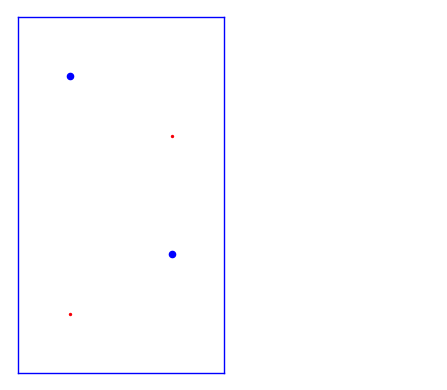

In [10]:
p = model4.plot()
model.show(p)

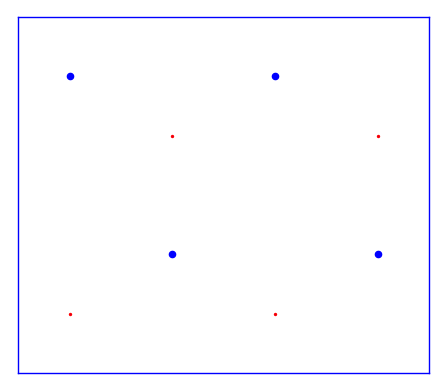

In [11]:
p = model8.plot()
model.show(p)

In [12]:
model4.ComputeForce(use_dxdy=False, use_d0 = True)
disp(model4.PotentialEnergy())

<IPython.core.display.Math object>

In [13]:
model4.ComputeForce(use_dxdy=False)
disp(model4.PotentialEnergy())

<IPython.core.display.Math object>

In [14]:
model4.ComputeForce(use_dxdy=True)
U = model4.PotentialEnergy()
disp(U)

<IPython.core.display.Math object>

In [15]:
Ut2 = model4.PotentialEnergyTaylor(2)
disp(Ut2)

<IPython.core.display.Math object>

In [16]:
disp(model4.KineticEnergy())

<IPython.core.display.Math object>

In [17]:
disp(model4.Lagrangian())

<IPython.core.display.Math object>

In [18]:
disp(model4.LagrangianTaylor(2))

<IPython.core.display.Math object>

обобщенные импульсы

$P = \frac{\partial L}{\partial \dot{x}} = \frac{\partial L}{\partial {v}}$

In [19]:
Px, Py = model4.Momentum()
disp(Px)
disp(Py)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [20]:
px, py = model4.momentum()
disp(px)
disp(py)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Запишем уравнения Эйлера-Лагранжа

$\frac{d}{dt}\frac{\partial L}{\partial \dot{x}} - \frac{\partial L}{\partial {x}} = 0$

In [21]:
eqs_x, eqs_y = model4.EulerLagrange(2)

In [22]:
for eq_x in eqs_x:
    disp(eq_x)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [23]:
for eq_y in eqs_y:
    disp(eq_y)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [24]:
eqsi_x, eqsi_y, Ax, Ay, Amx, Amy = model4.EulerLagrangeSolution(2)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [25]:
Matrix = GenerateMatrix(eqsi_x + eqsi_y, Ax + Ay)
disp(Matrix)

<IPython.core.display.Math object>

In [26]:
Matrix = GenerateMatrix(eqsi_x + eqsi_y, Amx + Amy)
disp(Matrix)

<IPython.core.display.Math object>

In [27]:
sympyMatrix = GenerateSympyMatrix(eqsi_x + eqsi_y, Amx + Amy)
sympyMatrix

Matrix([
[-M*omega**2 + 3*k/2,             -3*k/2,                   0,                  0,         sqrt(3)*k/2,       -sqrt(3)*k/2,                   0,                  0],
[             -3*k/2, 3*k/2 - m*omega**2,                   0,                  0,        -sqrt(3)*k/2,        sqrt(3)*k/2,                   0,                  0],
[                  0,                  0, -M*omega**2 + 3*k/2,             -3*k/2,                   0,                  0,        -sqrt(3)*k/2,        sqrt(3)*k/2],
[                  0,                  0,              -3*k/2, 3*k/2 - m*omega**2,                   0,                  0,         sqrt(3)*k/2,       -sqrt(3)*k/2],
[        sqrt(3)*k/2,       -sqrt(3)*k/2,                   0,                  0, -M*omega**2 + 3*k/2,               -k/2,                   0,                 -k],
[       -sqrt(3)*k/2,        sqrt(3)*k/2,                   0,                  0,                -k/2, 3*k/2 - m*omega**2,                  -k,                 

In [28]:
det_M = Matrix.det()
det_M.factor()

1/4*(2*M^2*m^2*omega^4 - 6*M^2*k*m*omega^2 - 6*M*k*m^2*omega^2 + 3*M^2*k^2 + 10*M*k^2*m + 3*k^2*m^2)*(2*M^2*m^2*omega^4 - 6*M^2*k*m*omega^2 - 6*M*k*m^2*omega^2 + 3*M^2*k^2 + 6*M*k^2*m + 3*k^2*m^2)*omega^8

In [29]:
sol_omega = solve(det_M == 0, omega)
for sol_omega_i in sol_omega:
    disp(sol_omega_i)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [30]:
for sol_omega_i in sol_omega:
    disp(sol_omega_i.subs(values))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

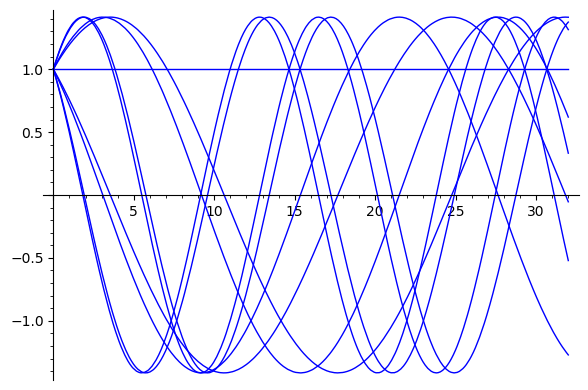

In [31]:
p = Graphics()
for sol_omega_i in sol_omega:
    p += plot((cos(omega*t)+sin(omega*t)).subs(sol_omega_i.subs(values)), t, 0, 32)
p.show()

обобщенные импульсы

$P = \frac{\partial L}{\partial \dot{x}} = \frac{\partial L}{\partial {v}}$

In [49]:
des0, f0, dvars = model8.numeric_des(n=0, show=False)

In [50]:
des0

[vx_0,
 vy_0,
 vx_1,
 vy_1,
 vx_2,
 vy_2,
 vx_3,
 vy_3,
 vx_4,
 vy_4,
 vx_5,
 vy_5,
 vx_6,
 vy_6,
 vx_7,
 vy_7,
 1/2*(sqrt(3)*k*l^2/sqrt(sqrt(3)*dx_0*l - sqrt(3)*dx_3*l + dx_0^2 - 2*dx_0*dx_3 + dx_3^2 + dy_0^2 - 2*dy_0*dy_3 + dy_3^2 - dy_0*l + dy_3*l + l^2) - 2*sqrt(3)*k*l^2/sqrt(-4*sqrt(3)*dx_0*l + 4*sqrt(3)*dx_2*l + 4*dx_0^2 - 8*dx_0*dx_2 + 4*dx_2^2 + 4*dy_0^2 - 8*dy_0*dy_2 + 4*dy_2^2 - 4*dy_0*l + 4*dy_2*l + 4*l^2) + 2*dx_0*k*l/sqrt(sqrt(3)*dx_0*l - sqrt(3)*dx_3*l + dx_0^2 - 2*dx_0*dx_3 + dx_3^2 + dy_0^2 - 2*dy_0*dy_3 + dy_3^2 - dy_0*l + dy_3*l + l^2) + 4*dx_0*k*l/sqrt(-4*sqrt(3)*dx_0*l + 4*sqrt(3)*dx_2*l + 4*dx_0^2 - 8*dx_0*dx_2 + 4*dx_2^2 + 4*dy_0^2 - 8*dy_0*dy_2 + 4*dy_2^2 - 4*dy_0*l + 4*dy_2*l + 4*l^2) + 2*dx_0*k*l/sqrt(dx_0^2 - 2*dx_0*dx_6 + dx_6^2 + dy_0^2 - 2*dy_0*dy_6 + dy_6^2 + 2*dy_0*l - 2*dy_6*l + l^2) - 4*dx_2*k*l/sqrt(-4*sqrt(3)*dx_0*l + 4*sqrt(3)*dx_2*l + 4*dx_0^2 - 8*dx_0*dx_2 + 4*dx_2^2 + 4*dy_0^2 - 8*dy_0*dy_2 + 4*dy_2^2 - 4*dy_0*l + 4*dy_2*l + 4*l^2) - 2*dx_3*k*l/sq

In [51]:
des2, f2, dvars = model8.numeric_des(n=2)

In [52]:
des3, f3, dvars = model8.numeric_des(n=3)

In [53]:
for des2_i in des2:
    disp(des2_i)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [54]:
for des3_i in des3:
    disp(des3_i)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [55]:
for des0_i in des0:
    disp(des0_i)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [105]:
# инициализация начальных условий

y0 = +0.001
#y0 = -0.01

ics=[0 for i in range(4*model.atom_count)]
ics[2*model.atom_count-3] = y0
#ics[2*model.atom_count-1] = y0
for i in range(4*model.atom_count):
    print(dvars[i], "(0) = ", ics[i])

dx_0 (0) =  0
dy_0 (0) =  0
dx_1 (0) =  0
dy_1 (0) =  0
dx_2 (0) =  0
dy_2 (0) =  0
dx_3 (0) =  0
dy_3 (0) =  0
dx_4 (0) =  0
dy_4 (0) =  0
dx_5 (0) =  0
dy_5 (0) =  0
dx_6 (0) =  0
dy_6 (0) =  0.00100000000000000
dx_7 (0) =  0
dy_7 (0) =  0
vx_0 (0) =  0
vy_0 (0) =  0
vx_1 (0) =  0
vy_1 (0) =  0
vx_2 (0) =  0
vy_2 (0) =  0
vx_3 (0) =  0
vy_3 (0) =  0
vx_4 (0) =  0
vy_4 (0) =  0
vx_5 (0) =  0
vy_5 (0) =  0
vx_6 (0) =  0
vy_6 (0) =  0
vx_7 (0) =  0
vy_7 (0) =  0


In [148]:
dt = 0.01
times = srange(0, 20000, dt)

In [149]:
# Solve numerically a system of first-order ordinary differential equations
# using odeint from scipy.integrate module.

# des – right hand sides of the system
# ics – initial conditions
# times – a sequence of time points in which the solution must be found
# dvars – dependent variables. ATTENTION: the order must be the same as in des, that means: d(dvars[i])/dt=des[i]
# ivar – independent variable, optional.

sol0 = desolve_odeint(des=f0, ics=ics, times=times, dvars=dvars, ivar=t)
sol2 = desolve_odeint(des=f2, ics=ics, times=times, dvars=dvars, ivar=t)
sol3 = desolve_odeint(des=f3, ics=ics, times=times, dvars=dvars, ivar=t)

In [150]:
colors = ["red", "green", "yellow", "blue", "pink", "brown", "aqua", "grey"]

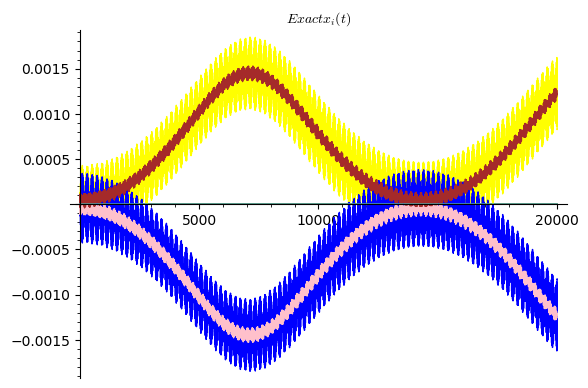

In [152]:
p = Graphics()
for i in range(model.atom_count):
    p += line(zip(times, sol0[:,2*i]), color=colors[i])
p.show(title="$Exact x_i(t)$")

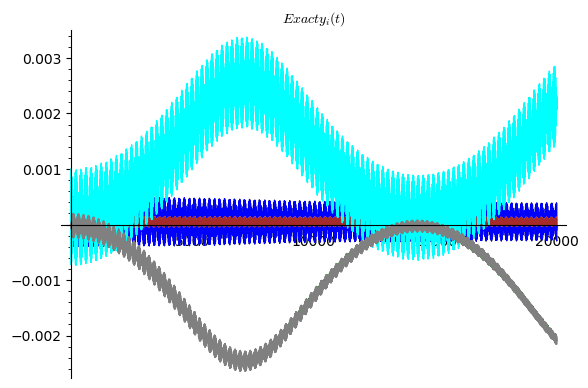

In [110]:
p = Graphics()
for i in range(model.atom_count):
    p += line(zip(times, sol0[:,2*i+1]), color=colors[i])
p.show(title="$Exact y_i(t)$")

In [138]:
len(sol0[0])

32

In [153]:
max_points=[[] for i in range(4*model.atom_count)]
for iatom in range(4*model.atom_count):
    for itime in range(len(sol0) - 2):
        if  sol0[itime, iatom] < sol0[itime + 1, iatom] \
        and sol0[itime + 1, iatom] > sol0[itime + 2, iatom]:
            max_points[iatom] += [itime + 1]

In [154]:
for iatom in range(4*model.atom_count):
    pre_point = 0
    for max_point in max_points[iatom]:
        dT = (max_point - pre_point) * dt
        print(iatom, dT)
        pre_point = max_point
        

0 1281.45000000000
0 0.570000000000000
0 0.0600000000000000
0 21.2500000000000
0 0.0300000000000000
0 9.88000000000000
0 6.66000000000000
0 22.7600000000000
0 0.380000000000000
0 1.09000000000000
0 4.76000000000000
0 3.35000000000000
0 1.84000000000000
0 5.49000000000000
0 18.3100000000000
0 1.39000000000000
0 5.75000000000000
0 11.6600000000000
0 1.70000000000000
0 1.03000000000000
0 24.0300000000000
0 12.8200000000000
0 15.8000000000000
0 14.1900000000000
0 1.66000000000000
0 0.870000000000000
0 0.390000000000000
0 20.0000000000000
0 18.2900000000000
0 18.9100000000000
0 18.5800000000000
0 19.6700000000000
0 0.230000000000000
0 9.03000000000000
0 8.83000000000000
0 20.4700000000000
0 17.7100000000000
0 17.1300000000000
0 35.2000000000000
0 0.130000000000000
0 1.21000000000000
0 17.8200000000000
0 18.9000000000000
0 17.0600000000000
0 21.0100000000000
0 17.6200000000000
0 0.0800000000000000
0 20.1900000000000
0 17.7300000000000
0 18.1600000000000
0 20.4800000000000
0 14.3000000000000


0 18.7500000000000
0 18.7700000000000
0 18.6900000000000
0 18.2500000000000
0 18.1300000000000
0 17.4100000000000
0 17.7300000000000
0 18.3000000000000
0 18.4700000000000
0 18.8400000000000
0 18.7300000000000
0 18.9000000000000
0 18.7800000000000
0 18.6900000000000
0 18.5500000000000
0 17.9500000000000
0 17.8000000000000
0 17.5300000000000
0 18.0000000000000
0 18.6600000000000
0 18.6000000000000
0 18.8900000000000
0 18.7800000000000
0 18.8100000000000
0 18.8000000000000
0 18.4300000000000
0 18.4400000000000
0 17.5800000000000
0 17.6500000000000
0 17.9600000000000
0 18.1700000000000
0 18.8300000000000
0 18.6700000000000
0 18.9100000000000
0 18.8400000000000
0 18.7000000000000
0 18.7500000000000
0 18.2200000000000
0 18.0700000000000
0 17.4900000000000
0 17.6500000000000
0 18.3800000000000
0 18.4600000000000
0 18.8300000000000
0 18.7900000000000
0 18.8500000000000
0 18.8400000000000
0 18.6200000000000
0 18.6300000000000
0 17.9400000000000
0 17.7400000000000
0 17.5800000000000
0 18.0600000

1 18.3900000000000
1 18.2900000000000
1 18.6500000000000
1 18.1700000000000
1 18.6300000000000
1 18.2900000000000
1 18.3400000000000
1 18.5300000000000
1 18.1000000000000
1 18.6200000000000
1 18.2000000000000
1 18.4400000000000
1 18.5100000000000
1 18.2200000000000
1 18.6900000000000
1 18.1900000000000
1 18.5300000000000
1 18.3800000000000
1 18.2200000000000
1 18.6000000000000
1 18.1000000000000
1 18.5800000000000
1 18.3000000000000
1 18.3500000000000
1 18.6100000000000
1 18.1800000000000
1 18.6700000000000
1 18.2400000000000
1 18.4200000000000
1 18.4800000000000
1 18.1300000000000
1 18.6300000000000
1 18.1400000000000
1 18.5000000000000
1 18.4300000000000
1 18.2600000000000
1 18.6700000000000
1 18.1800000000000
1 18.6000000000000
1 18.3200000000000
1 18.3000000000000
1 18.5600000000000
1 18.0900000000000
1 18.6100000000000
1 18.2300000000000
1 18.4100000000000
1 18.5400000000000
1 18.2000000000000
1 18.6900000000000
1 18.2100000000000
1 18.5000000000000
1 18.4200000000000
1 18.1800000

2 18.7400000000000
2 18.4700000000000
2 18.5500000000000
2 18.4900000000000
2 18.1200000000000
2 18.3800000000000
2 17.9300000000000
2 18.2000000000000
2 18.4000000000000
2 18.3100000000000
2 18.6700000000000
2 18.4600000000000
2 18.6400000000000
2 18.5800000000000
2 18.3900000000000
2 18.5100000000000
2 18.0300000000000
2 18.2900000000000
2 18.0100000000000
2 18.1500000000000
2 18.5300000000000
2 18.3200000000000
2 18.7100000000000
2 18.5300000000000
2 18.6000000000000
2 18.5900000000000
2 18.1700000000000
2 18.4500000000000
2 17.9300000000000
2 18.1300000000000
2 18.2300000000000
2 18.1800000000000
2 18.6500000000000
2 18.4500000000000
2 18.6900000000000
2 18.5700000000000
2 18.5500000000000
2 18.5500000000000
2 18.1500000000000
2 18.2600000000000
2 17.9700000000000
2 18.0900000000000
2 18.3700000000000
2 18.3000000000000
2 18.6900000000000
2 18.5400000000000
2 18.6300000000000
2 18.6800000000000
2 18.3500000000000
2 18.5400000000000
2 17.9500000000000
2 18.2100000000000
2 18.0400000

3 20.3200000000000
3 18.0100000000000
3 21.2600000000000
3 17.4700000000000
3 22.4000000000000
3 17.6700000000000
3 28.6400000000000
3 16.7600000000000
3 20.5900000000000
3 19.5100000000000
3 18.6200000000000
3 20.7300000000000
3 17.7400000000000
3 21.5800000000000
3 17.4100000000000
3 42.9100000000000
3 24.8300000000000
3 18.2600000000000
3 19.5800000000000
3 20.0600000000000
3 18.2000000000000
3 21.0800000000000
3 17.5500000000000
3 21.9700000000000
3 17.5200000000000
3 45.2400000000000
3 21.5600000000000
3 19.1400000000000
3 18.9100000000000
3 20.5100000000000
3 17.8900000000000
3 21.3900000000000
3 17.4500000000000
3 22.8100000000000
3 18.0300000000000
3 27.4800000000000
3 17.4100000000000
3 20.1200000000000
3 19.7700000000000
3 18.4200000000000
3 20.9000000000000
3 17.6500000000000
3 21.7200000000000
3 17.4600000000000
3 44.1500000000000
3 23.2400000000000
3 18.6300000000000
3 19.2700000000000
3 20.2700000000000
3 18.0500000000000
3 21.2300000000000
3 17.5000000000000
3 22.2000000

4 19.7900000000000
4 19.5300000000000
4 19.4400000000000
4 19.4900000000000
4 19.4100000000000
4 19.6100000000000
4 19.6500000000000
4 20.6500000000000
4 23.1300000000000
4 21.2300000000000
4 19.8000000000000
4 19.5900000000000
4 19.4900000000000
4 19.4200000000000
4 19.5100000000000
4 19.4500000000000
4 19.7500000000000
4 20.1000000000000
4 22.8700000000000
4 21.7100000000000
4 20.0900000000000
4 19.6000000000000
4 19.4900000000000
4 19.4900000000000
4 19.4100000000000
4 19.5600000000000
4 19.5400000000000
4 20.1000000000000
4 21.6300000000000
4 22.8900000000000
4 20.1600000000000
4 19.7200000000000
4 19.5300000000000
4 19.4400000000000
4 19.5000000000000
4 19.4200000000000
4 19.6600000000000
4 19.7600000000000
4 21.1500000000000
4 23.0200000000000
4 20.7300000000000
4 19.7400000000000
4 19.5600000000000
4 19.5000000000000
4 19.4200000000000
4 19.5300000000000
4 19.4800000000000
4 19.8300000000000
4 20.4000000000000
4 23.2300000000000
4 21.0700000000000
4 19.9500000000000
4 19.5900000

5 19.4600000000000
5 27.9100000000000
5 19.3700000000000
5 19.4500000000000
5 19.2500000000000
5 19.3000000000000
5 19.2900000000000
5 19.2500000000000
5 19.3600000000000
5 19.2400000000000
5 19.6600000000000
5 27.0700000000000
5 20.2600000000000
5 19.2700000000000
5 19.3700000000000
5 19.2600000000000
5 19.2800000000000
5 19.3100000000000
5 19.2400000000000
5 19.4100000000000
5 19.2800000000000
5 21.6900000000000
5 25.6800000000000
5 19.5800000000000
5 19.2500000000000
5 19.3300000000000
5 19.2800000000000
5 19.2600000000000
5 19.3400000000000
5 19.2300000000000
5 19.4900000000000
5 19.5400000000000
5 27.8200000000000
5 19.3600000000000
5 19.4400000000000
5 19.2500000000000
5 19.3000000000000
5 19.3000000000000
5 19.2500000000000
5 19.3700000000000
5 19.2400000000000
5 19.7000000000000
5 27.1500000000000
5 20.1200000000000
5 19.2700000000000
5 19.3700000000000
5 19.2700000000000
5 19.2700000000000
5 19.3300000000000
5 19.2300000000000
5 19.4200000000000
5 19.3000000000000
5 26.7900000

5 19.0700000000000
5 18.7600000000000
5 18.1700000000000
5 14.4300000000000
5 17.3900000000000
5 18.8200000000000
5 18.9400000000000
5 19.1900000000000
5 19.0500000000000
5 19.2000000000000
5 19.0900000000000
5 19.0700000000000
5 18.9900000000000
5 18.0900000000000
5 15.5900000000000
5 16.2900000000000
5 18.5800000000000
5 19.0800000000000
5 19.0000000000000
5 19.2100000000000
5 19.0700000000000
5 19.1700000000000
5 19.0900000000000
5 18.9200000000000
5 18.7100000000000
5 15.7400000000000
5 15.8200000000000
5 18.4300000000000
5 18.8800000000000
5 19.1700000000000
5 19.0400000000000
5 19.2100000000000
5 19.0900000000000
5 19.1100000000000
5 19.0500000000000
5 18.5800000000000
5 17.2400000000000
5 14.6200000000000
5 18.1400000000000
5 18.9700000000000
5 18.9800000000000
5 19.2100000000000
5 19.0700000000000
5 19.1900000000000
5 19.0900000000000
5 19.0200000000000
5 18.9300000000000
5 17.3000000000000
5 14.8800000000000
5 17.6200000000000
5 18.7800000000000
5 19.1300000000000
5 19.0300000

6 19.4500000000000
6 19.5200000000000
6 19.7100000000000
6 20.0700000000000
6 22.4400000000000
6 21.9500000000000
6 20.2300000000000
6 19.5800000000000
6 19.5900000000000
6 19.4200000000000
6 19.5000000000000
6 19.5000000000000
6 19.5900000000000
6 20.0300000000000
6 21.2300000000000
6 23.0400000000000
6 20.3100000000000
6 19.8300000000000
6 19.4800000000000
6 19.5300000000000
6 19.4300000000000
6 19.5000000000000
6 19.6000000000000
6 19.7600000000000
6 20.8600000000000
6 22.8700000000000
6 21.0700000000000
6 19.7600000000000
6 19.6600000000000
6 19.4400000000000
6 19.5000000000000
6 19.4700000000000
6 19.5300000000000
6 19.7600000000000
6 20.2200000000000
6 22.8000000000000
6 21.4900000000000
6 20.1300000000000
6 19.5600000000000
6 19.5700000000000
6 19.4300000000000
6 19.5000000000000
6 19.5200000000000
6 19.6100000000000
6 20.1400000000000
6 21.5900000000000
6 22.7200000000000
6 20.1500000000000
6 19.8000000000000
6 19.4700000000000
6 19.5300000000000
6 19.4400000000000
6 19.5000000

7 19.3400000000000
7 19.1600000000000
7 29.0100000000000
7 19.1100000000000
7 19.2900000000000
7 19.2400000000000
7 19.2100000000000
7 19.3000000000000
7 19.1700000000000
7 19.3200000000000
7 19.1300000000000
7 19.2500000000000
7 13.5300000000000
7 15.4000000000000
7 19.3600000000000
7 19.1700000000000
7 19.2400000000000
7 19.2600000000000
7 19.1800000000000
7 19.3100000000000
7 19.1400000000000
7 19.3000000000000
7 19.0600000000000
7 15.9000000000000
7 13.6200000000000
7 18.8600000000000
7 19.2700000000000
7 19.2100000000000
7 19.2000000000000
7 19.2800000000000
7 19.1600000000000
7 19.3000000000000
7 19.1100000000000
7 19.2100000000000
7 18.0200000000000
7 11.3300000000000
7 19.1900000000000
7 19.0700000000000
7 19.2300000000000
7 19.2300000000000
7 19.1800000000000
7 19.2800000000000
7 19.1300000000000
7 19.2800000000000
7 19.0400000000000
7 18.5400000000000
7 12.1200000000000
7 17.9200000000000
7 19.2300000000000
7 19.1500000000000
7 19.2000000000000
7 19.2500000000000
7 19.1500000

8 17.7800000000000
8 19.5000000000000
8 17.4800000000000
8 16.4800000000000
8 19.0500000000000
8 16.6600000000000
8 19.5700000000000
8 18.4100000000000
8 18.7900000000000
8 19.4100000000000
8 18.1100000000000
8 19.8100000000000
8 17.6200000000000
8 18.7600000000000
8 17.7000000000000
8 15.7700000000000
8 19.6900000000000
8 17.4300000000000
8 19.2700000000000
8 18.8700000000000
8 18.5000000000000
8 19.6500000000000
8 17.9000000000000
8 19.7100000000000
8 17.5200000000000
8 17.4000000000000
8 18.4100000000000
8 16.1600000000000
8 19.6900000000000
8 18.0900000000000
8 18.9600000000000
8 19.2400000000000
8 18.2500000000000
8 19.7900000000000
8 17.7300000000000
8 19.2800000000000
8 17.5600000000000
8 16.0200000000000
8 19.3800000000000
8 16.9500000000000
8 19.4400000000000
8 18.6200000000000
8 18.6600000000000
8 19.5300000000000
8 18.0200000000000
8 19.8100000000000
8 17.6000000000000
8 18.2800000000000
8 17.9300000000000
8 15.7700000000000
8 19.7500000000000
8 17.7100000000000
8 19.1300000

9 19.1300000000000
9 16.5400000000000
9 18.5400000000000
9 19.1300000000000
9 18.1200000000000
9 19.7700000000000
9 18.1200000000000
9 19.4700000000000
9 18.5200000000000
9 18.0100000000000
9 19.2000000000000
9 15.3800000000000
9 18.9200000000000
9 17.7700000000000
9 18.3000000000000
9 19.5200000000000
9 18.0700000000000
9 19.7500000000000
9 18.2400000000000
9 19.1100000000000
9 18.7800000000000
9 17.0100000000000
9 19.2700000000000
9 15.6500000000000
9 18.6300000000000
9 18.7100000000000
9 18.1400000000000
9 19.7300000000000
9 18.0900000000000
9 19.6100000000000
9 18.4200000000000
9 18.5600000000000
9 19.1000000000000
9 15.9300000000000
9 19.0400000000000
9 16.8100000000000
9 18.3600000000000
9 19.3000000000000
9 18.0600000000000
9 19.7800000000000
9 18.1700000000000
9 19.3500000000000
9 18.6700000000000
9 17.7800000000000
9 19.3400000000000
9 15.3600000000000
9 18.7300000000000
9 18.0600000000000
9 18.1500000000000
9 19.6400000000000
9 18.0500000000000
9 19.7100000000000
9 18.3200000

9 19.3800000000000
9 17.3100000000000
9 16.9900000000000
9 19.3200000000000
9 17.0000000000000
9 19.6200000000000
9 18.2300000000000
9 18.7600000000000
9 19.2900000000000
9 17.8400000000000
9 19.8100000000000
9 17.2000000000000
9 18.5900000000000
9 17.9200000000000
9 16.6000000000000
9 19.7200000000000
9 17.4400000000000
9 19.3200000000000
9 18.6800000000000
9 18.3900000000000
9 19.5900000000000
9 17.5600000000000
9 19.6700000000000
9 17.2200000000000
9 17.5400000000000
9 18.7900000000000
9 16.7000000000000
9 19.7400000000000
9 17.9100000000000
9 18.9700000000000
9 19.0800000000000
9 18.0500000000000
9 19.7900000000000
9 17.3400000000000
9 19.1700000000000
9 17.5400000000000
9 16.7400000000000
9 19.5000000000000
9 17.0700000000000
9 19.5100000000000
9 18.4000000000000
9 18.6000000000000
9 19.4300000000000
9 17.7500000000000
9 19.8000000000000
9 17.2600000000000
9 18.2500000000000
9 18.2300000000000
9 16.5000000000000
9 19.7600000000000
9 17.5700000000000
9 19.1800000000000
9 18.8400000

10 19.6800000000000
10 17.7700000000000
10 20.4700000000000
10 15.2300000000000
10 15.2900000000000
10 19.7300000000000
10 17.2900000000000
10 20.1000000000000
10 18.3600000000000
10 19.3700000000000
10 19.1900000000000
10 18.5000000000000
10 20.0000000000000
10 17.1900000000000
10 20.1300000000000
10 14.5600000000000
10 15.7400000000000
10 20.3900000000000
10 17.7400000000000
10 19.8400000000000
10 18.6800000000000
10 19.0600000000000
10 19.5000000000000
10 18.1100000000000
10 20.3000000000000
10 16.4000000000000
10 17.0700000000000
10 17.3000000000000
10 16.6500000000000
10 20.2800000000000
10 18.1200000000000
10 19.5400000000000
10 19.0100000000000
10 18.7200000000000
10 19.8200000000000
10 17.6800000000000
10 20.4600000000000
10 15.3300000000000
10 14.8200000000000
10 20.1500000000000
10 17.3000000000000
10 20.0200000000000
10 18.4800000000000
10 19.2400000000000
10 19.3200000000000
10 18.3800000000000
10 20.1000000000000
10 17.1600000000000
10 19.7400000000000
10 15.0000000000000


11 17.7200000000000
11 19.6600000000000
11 16.3900000000000
11 18.4600000000000
11 17.9800000000000
11 17.4800000000000
11 19.7100000000000
11 17.7600000000000
11 19.5300000000000
11 18.4700000000000
11 18.5700000000000
11 19.3300000000000
11 17.1300000000000
11 19.5300000000000
11 16.5200000000000
11 17.8400000000000
11 18.9400000000000
11 17.4900000000000
11 19.7800000000000
11 17.9900000000000
11 19.2300000000000
11 18.7900000000000
11 18.0800000000000
11 19.5900000000000
11 16.6500000000000
11 18.9600000000000
11 17.2800000000000
11 17.4900000000000
11 19.5300000000000
11 17.6100000000000
11 19.6700000000000
11 18.2700000000000
11 18.8400000000000
11 19.1500000000000
11 17.5200000000000
11 19.6800000000000
11 16.4400000000000
11 18.2000000000000
11 18.3300000000000
11 17.4000000000000
11 19.7600000000000
11 17.8200000000000
11 19.4200000000000
11 18.6000000000000
11 18.3900000000000
11 19.4600000000000
11 17.0100000000000
11 19.3900000000000
11 16.7600000000000
11 17.6100000000000


12 18.4700000000000
12 18.6500000000000
12 18.6900000000000
12 18.7300000000000
12 18.6700000000000
12 18.5900000000000
12 18.4300000000000
12 18.1700000000000
12 17.9600000000000
12 17.8900000000000
12 18.1400000000000
12 18.4000000000000
12 18.5600000000000
12 18.6900000000000
12 18.7100000000000
12 18.7000000000000
12 18.6300000000000
12 18.4600000000000
12 18.2600000000000
12 17.9700000000000
12 17.9300000000000
12 18.0700000000000
12 18.3300000000000
12 18.5600000000000
12 18.6300000000000
12 18.7200000000000
12 18.7100000000000
12 18.6200000000000
12 18.5300000000000
12 18.2900000000000
12 18.0900000000000
12 17.9000000000000
12 18.0200000000000
12 18.2800000000000
12 18.4700000000000
12 18.6100000000000
12 18.6800000000000
12 18.7000000000000
12 18.6600000000000
12 18.5300000000000
12 18.4200000000000
12 18.1000000000000
12 17.9600000000000
12 17.9400000000000
12 18.1900000000000
12 18.4500000000000
12 18.5500000000000
12 18.6900000000000
12 18.6800000000000
12 18.6800000000000


13 16.3200000000000
13 17.6500000000000
13 18.7100000000000
13 18.8900000000000
13 19.0000000000000
13 19.0700000000000
13 19.0000000000000
13 19.0500000000000
13 18.8300000000000
13 18.6300000000000
13 17.5900000000000
13 16.0500000000000
13 17.5700000000000
13 18.4600000000000
13 18.9100000000000
13 18.9900000000000
13 19.0200000000000
13 19.0800000000000
13 18.9600000000000
13 18.9800000000000
13 18.6200000000000
13 17.9000000000000
13 16.3800000000000
13 16.9300000000000
13 18.4800000000000
13 18.7900000000000
13 18.9900000000000
13 19.0500000000000
13 19.0100000000000
13 19.0700000000000
13 18.8900000000000
13 18.8000000000000
13 18.1100000000000
13 16.5000000000000
13 16.8300000000000
13 18.1200000000000
13 18.8200000000000
13 18.9400000000000
13 19.0100000000000
13 19.0800000000000
13 18.9800000000000
13 19.0300000000000
13 18.7500000000000
13 18.3700000000000
13 16.9600000000000
13 16.2700000000000
13 18.1000000000000
13 18.6500000000000
13 18.9500000000000
13 19.0200000000000


14 6.98000000000000
14 12.7800000000000
14 16.9200000000000
14 7.63000000000000
14 9.43000000000000
14 4.56000000000000
14 4.71000000000000
14 15.2700000000000
14 19.7300000000000
14 19.4400000000000
14 19.1000000000000
14 19.2900000000000
14 9.48000000000000
14 10.2500000000000
14 19.5600000000000
14 19.4900000000000
14 0.0400000000000000
14 19.2600000000000
14 29.0300000000000
14 18.2100000000000
14 19.6300000000000
14 19.2000000000000
14 19.0600000000000
14 18.7900000000000
14 19.0700000000000
14 19.1000000000000
14 19.2000000000000
14 19.5600000000000
14 19.1900000000000
14 17.9600000000000
14 5.79000000000000
14 9.48000000000000
14 0.120000000000000
14 5.78000000000000
14 2.19000000000000
14 7.51000000000000
14 18.2400000000000
14 0.110000000000000
14 1.24000000000000
14 18.2800000000000
14 19.6200000000000
14 19.3000000000000
14 19.0300000000000
14 18.9400000000000
14 19.3400000000000
14 19.4600000000000
14 13.6700000000000
14 7.25000000000000
14 16.4000000000000
14 0.60000000000

14 19.9200000000000
14 19.4700000000000
14 19.3700000000000
14 19.3600000000000
14 19.3300000000000
14 19.3100000000000
14 19.3900000000000
14 19.4300000000000
14 19.9900000000000
14 26.2200000000000
14 20.1400000000000
14 19.4700000000000
14 19.3800000000000
14 19.3300000000000
14 19.3200000000000
14 19.3100000000000
14 19.3000000000000
14 19.3900000000000
14 19.5100000000000
14 26.3400000000000
14 20.6800000000000
14 19.5000000000000
14 19.3500000000000
14 19.3300000000000
14 19.2900000000000
14 19.2800000000000
14 19.2900000000000
14 19.3100000000000
14 19.4200000000000
14 20.1200000000000
14 27.1300000000000
14 19.5300000000000
14 19.3400000000000
14 19.3000000000000
14 19.2800000000000
14 19.2800000000000
14 19.2700000000000
14 19.2600000000000
14 19.2700000000000
14 19.3100000000000
14 28.2300000000000
14 19.5200000000000
14 19.3300000000000
14 19.3000000000000
14 19.2700000000000
14 19.2500000000000
14 19.2400000000000
14 19.2300000000000
14 19.2300000000000
14 19.2300000000000


15 18.2300000000000
15 18.2700000000000
15 18.4200000000000
15 18.1800000000000
15 18.5500000000000
15 18.3200000000000
15 18.5000000000000
15 18.5200000000000
15 18.3400000000000
15 18.6100000000000
15 18.2700000000000
15 18.4700000000000
15 18.3300000000000
15 18.2200000000000
15 18.4600000000000
15 18.1500000000000
15 18.5000000000000
15 18.3500000000000
15 18.4000000000000
15 18.5800000000000
15 18.3300000000000
15 18.6300000000000
15 18.3400000000000
15 18.4300000000000
15 18.4200000000000
15 18.1500000000000
15 18.4400000000000
15 18.1300000000000
15 18.4000000000000
15 18.4100000000000
15 18.3600000000000
15 18.6500000000000
15 18.3800000000000
15 18.6300000000000
15 18.4300000000000
15 18.3700000000000
15 18.4500000000000
15 18.0500000000000
15 18.3700000000000
15 18.1300000000000
15 18.3200000000000
15 18.5200000000000
15 18.3700000000000
15 18.7200000000000
15 18.4600000000000
15 18.6200000000000
15 18.5100000000000
15 18.2700000000000
15 18.4200000000000
15 17.9300000000000


16 8.44000000000000
16 7.18000000000000
16 19.4200000000000
16 16.6300000000000
16 19.2100000000000
16 18.4100000000000
16 18.6000000000000
16 19.6000000000000
16 18.2100000000000
16 19.5400000000000
16 18.0900000000000
16 18.3900000000000
16 18.3100000000000
16 14.8400000000000
16 10.3100000000000
16 9.25000000000000
16 18.0600000000000
16 18.9300000000000
16 19.0600000000000
16 18.6000000000000
16 19.5600000000000
16 18.1500000000000
16 19.2900000000000
16 18.1900000000000
16 15.7700000000000
16 18.8300000000000
16 16.3100000000000
16 19.5100000000000
16 18.5900000000000
16 18.6800000000000
16 19.5800000000000
16 18.2700000000000
16 19.6600000000000
16 8.95000000000000
16 9.25000000000000
16 18.7000000000000
16 17.4900000000000
16 15.2200000000000
16 19.3600000000000
16 17.9700000000000
16 19.0100000000000
16 18.9600000000000
16 18.5600000000000
16 19.5500000000000
16 18.3900000000000
16 19.5200000000000
16 17.9100000000000
16 17.7700000000000
16 17.4000000000000
16 7.85000000000000


17 18.3900000000000
17 18.5900000000000
17 18.4200000000000
17 18.5500000000000
17 18.4100000000000
17 18.3400000000000
17 18.3900000000000
17 18.1500000000000
17 18.3700000000000
17 18.2500000000000
17 18.3800000000000
17 18.5000000000000
17 18.4000000000000
17 18.6000000000000
17 18.4200000000000
17 18.4800000000000
17 18.4200000000000
17 18.2500000000000
17 18.3700000000000
17 18.1700000000000
17 18.3600000000000
17 18.3400000000000
17 18.3900000000000
17 18.5500000000000
17 18.4100000000000
17 18.5800000000000
17 18.4200000000000
17 18.4000000000000
17 18.4100000000000
17 18.1900000000000
17 18.3600000000000
17 18.2100000000000
17 18.3600000000000
17 18.4400000000000
17 18.3900000000000
17 18.5900000000000
17 18.4100000000000
17 18.5300000000000
17 18.4200000000000
17 18.3200000000000
17 18.4000000000000
17 18.1600000000000
17 18.3600000000000
17 18.2800000000000
17 18.3600000000000
17 18.5200000000000
17 18.3900000000000
17 18.5900000000000
17 18.4200000000000
17 18.4600000000000


18 1.56000000000000
18 0.710000000000000
18 6.10000000000000
18 0.900000000000000
18 2.09000000000000
18 3.29000000000000
18 1.32000000000000
18 2.64000000000000
18 1.69000000000000
18 5.05000000000000
18 1.03000000000000
18 1.80000000000000
18 1.98000000000000
18 2.00000000000000
18 1.33000000000000
18 4.83000000000000
18 1.53000000000000
18 1.90000000000000
18 0.950000000000000
18 0.490000000000000
18 1.37000000000000
18 3.51000000000000
18 0.560000000000000
18 9.55000000000000
18 1.72000000000000
18 5.23000000000000
18 3.15000000000000
18 4.04000000000000
18 1.76000000000000
18 3.09000000000000
18 3.02000000000000
18 5.21000000000000
18 3.68000000000000
18 4.80000000000000
18 1.86000000000000
18 1.85000000000000
18 5.56000000000000
18 3.70000000000000
18 6.31000000000000
18 5.44000000000000
18 3.54000000000000
18 1.75000000000000
18 1.89000000000000
18 0.990000000000000
18 2.51000000000000
18 1.31000000000000
18 5.66000000000000
18 2.10000000000000
18 2.14000000000000
18 8.300000000

18 17.9300000000000
18 17.6200000000000
18 18.1100000000000
18 18.3400000000000
18 18.5900000000000
18 18.7700000000000
18 18.7100000000000
18 18.8000000000000
18 18.6600000000000
18 18.5700000000000
18 18.2700000000000
18 17.8200000000000
18 17.8300000000000
18 17.7900000000000
18 18.3800000000000
18 18.5500000000000
18 18.6700000000000
18 18.8000000000000
18 18.7100000000000
18 18.7900000000000
18 18.5700000000000
18 18.3800000000000
18 18.0400000000000
18 17.6900000000000
18 17.8800000000000
18 18.1000000000000
18 18.5200000000000
18 18.6600000000000
18 18.7100000000000
18 18.8000000000000
18 18.7400000000000
18 18.7100000000000
18 18.3900000000000
18 18.1300000000000
18 17.8100000000000
18 17.6200000000000
18 18.1900000000000
18 18.3600000000000
18 18.6400000000000
18 18.7700000000000
18 18.7200000000000
18 18.8500000000000
18 18.6100000000000
18 18.5900000000000
18 18.2700000000000
18 17.8000000000000
18 17.7800000000000
18 17.8400000000000
18 18.3600000000000
18 18.5700000000000


19 17.9600000000000
19 21.1800000000000
19 18.9800000000000
19 19.4600000000000
19 19.6900000000000
19 18.8000000000000
19 20.2600000000000
19 18.4400000000000
19 21.2100000000000
19 18.9500000000000
19 26.9200000000000
19 18.3200000000000
19 20.2400000000000
19 19.2900000000000
19 19.1600000000000
19 19.9100000000000
19 18.6300000000000
19 20.4900000000000
19 18.4100000000000
19 22.7200000000000
19 21.1400000000000
19 23.0400000000000
19 18.7700000000000
19 19.7000000000000
19 19.5600000000000
19 18.9200000000000
19 20.1200000000000
19 18.5100000000000
19 20.7500000000000
19 18.5600000000000
19 27.4000000000000
19 18.1000000000000
19 20.8900000000000
19 19.1300000000000
19 19.3300000000000
19 19.8000000000000
19 18.7200000000000
19 20.3200000000000
19 18.4500000000000
19 21.2100000000000
19 19.4000000000000
19 26.3500000000000
19 18.5200000000000
19 20.0400000000000
19 19.4300000000000
19 19.0400000000000
19 20.0100000000000
19 18.5800000000000
19 20.5100000000000
19 18.4900000000000


20 21.2600000000000
20 19.8900000000000
20 19.5200000000000
20 19.4700000000000
20 19.4300000000000
20 19.4200000000000
20 19.4900000000000
20 19.5600000000000
20 20.0700000000000
20 22.2800000000000
20 22.6700000000000
20 19.9800000000000
20 19.6400000000000
20 19.4600000000000
20 19.4300000000000
20 19.4400000000000
20 19.4400000000000
20 19.5800000000000
20 19.7800000000000
20 21.3300000000000
20 23.4200000000000
20 20.4200000000000
20 19.6400000000000
20 19.5200000000000
20 19.4400000000000
20 19.4200000000000
20 19.4600000000000
20 19.4900000000000
20 19.7500000000000
20 20.4700000000000
20 23.7700000000000
20 20.8400000000000
20 19.8300000000000
20 19.5100000000000
20 19.4600000000000
20 19.4300000000000
20 19.4300000000000
20 19.5100000000000
20 19.5900000000000
20 20.2000000000000
20 22.8300000000000
20 22.0400000000000
20 19.9000000000000
20 19.6100000000000
20 19.4600000000000
20 19.4300000000000
20 19.4400000000000
20 19.4500000000000
20 19.6000000000000
20 19.8600000000000


21 19.2200000000000
21 19.2000000000000
21 19.2400000000000
21 19.1500000000000
21 19.1800000000000
21 18.3800000000000
21 11.7400000000000
21 18.5100000000000
21 19.0500000000000
21 19.2200000000000
21 19.1900000000000
21 19.2200000000000
21 19.2200000000000
21 19.1800000000000
21 19.2200000000000
21 19.0700000000000
21 18.8400000000000
21 12.7700000000000
21 17.1400000000000
21 19.1100000000000
21 19.1200000000000
21 19.2200000000000
21 19.1900000000000
21 19.2100000000000
21 19.2100000000000
21 19.1500000000000
21 19.1800000000000
21 18.7700000000000
21 14.5800000000000
21 15.6200000000000
21 18.8400000000000
21 19.1800000000000
21 19.1500000000000
21 19.2100000000000
21 19.2000000000000
21 19.1800000000000
21 19.2100000000000
21 19.0800000000000
21 19.0000000000000
21 16.2600000000000
21 13.9400000000000
21 18.8100000000000
21 19.0400000000000
21 19.2000000000000
21 19.1700000000000
21 19.1900000000000
21 19.2100000000000
21 19.1400000000000
21 19.1700000000000
21 18.9100000000000


22 19.4400000000000
22 19.2600000000000
22 19.2500000000000
22 19.2800000000000
22 19.2300000000000
22 19.2800000000000
22 19.2300000000000
22 19.2800000000000
22 19.2800000000000
22 19.5600000000000
22 8.90000000000000
22 19.4700000000000
22 19.3000000000000
22 19.2700000000000
22 19.2400000000000
22 19.2800000000000
22 19.2300000000000
22 19.2900000000000
22 19.2400000000000
22 19.2900000000000
22 19.4500000000000
22 28.4800000000000
22 19.2900000000000
22 19.2700000000000
22 19.2800000000000
22 19.2300000000000
22 19.2900000000000
22 19.2300000000000
22 19.2900000000000
22 19.2600000000000
22 19.3600000000000
22 15.5800000000000
22 12.8500000000000
22 19.4200000000000
22 19.2800000000000
22 19.2600000000000
22 19.2800000000000
22 19.2300000000000
22 19.2900000000000
22 19.2400000000000
22 19.3000000000000
22 19.3400000000000
22 28.3600000000000
22 19.4500000000000
22 19.3100000000000
22 19.2900000000000
22 19.2400000000000
22 19.2900000000000
22 19.2400000000000
22 19.2900000000000


23 19.2600000000000
23 19.2600000000000
23 19.2300000000000
23 19.3000000000000
23 19.2100000000000
23 28.7600000000000
23 19.2400000000000
23 19.3200000000000
23 19.2200000000000
23 19.2700000000000
23 19.2400000000000
23 19.2500000000000
23 19.2700000000000
23 19.2200000000000
23 19.3400000000000
23 19.3300000000000
23 8.98000000000000
23 19.6800000000000
23 19.2100000000000
23 19.2900000000000
23 19.2400000000000
23 19.2500000000000
23 19.2600000000000
23 19.2300000000000
23 19.2900000000000
23 19.2100000000000
23 19.4800000000000
23 28.5000000000000
23 19.3500000000000
23 19.2200000000000
23 19.2800000000000
23 19.2400000000000
23 19.2500000000000
23 19.2600000000000
23 19.2300000000000
23 19.3100000000000
23 19.2100000000000
23 14.1000000000000
23 14.7000000000000
23 19.2100000000000
23 19.3100000000000
23 19.2200000000000
23 19.2600000000000
23 19.2500000000000
23 19.2400000000000
23 19.2800000000000
23 19.2100000000000
23 19.3500000000000
23 28.5600000000000
23 19.4400000000000


23 17.0400000000000
23 15.5100000000000
23 18.0300000000000
23 18.7600000000000
23 18.9900000000000
23 19.0900000000000
23 19.0700000000000
23 19.1200000000000
23 19.0300000000000
23 19.0100000000000
23 18.7000000000000
23 17.6000000000000
23 15.5800000000000
23 17.2900000000000
23 18.6900000000000
23 18.9600000000000
23 19.0400000000000
23 19.1100000000000
23 19.0700000000000
23 19.1000000000000
23 18.9800000000000
23 18.8400000000000
23 18.1400000000000
23 15.7300000000000
23 16.7800000000000
23 18.4200000000000
23 18.9100000000000
23 19.0500000000000
23 19.0600000000000
23 19.1300000000000
23 19.0500000000000
23 19.0600000000000
23 18.8800000000000
23 18.4100000000000
23 16.6100000000000
23 15.8200000000000
23 18.2600000000000
23 18.8200000000000
23 19.0000000000000
23 19.1000000000000
23 19.0600000000000
23 19.1300000000000
23 19.0200000000000
23 18.9700000000000
23 18.6200000000000
23 17.1700000000000
23 15.6400000000000
23 17.6800000000000
23 18.7600000000000
23 18.9900000000000


24 19.3400000000000
24 18.7500000000000
24 18.4600000000000
24 18.3900000000000
24 14.6800000000000
24 18.2800000000000
24 18.3800000000000
24 18.7500000000000
24 19.3200000000000
24 18.6900000000000
24 19.4400000000000
24 18.7100000000000
24 19.1600000000000
24 18.7800000000000
24 17.3800000000000
24 17.4700000000000
24 15.8000000000000
24 18.6800000000000
24 18.9500000000000
24 18.7100000000000
24 19.4200000000000
24 18.6800000000000
24 19.3900000000000
24 18.7500000000000
24 18.8300000000000
24 18.7200000000000
24 15.4700000000000
24 17.5700000000000
24 17.6600000000000
24 18.7300000000000
24 19.2300000000000
24 18.6900000000000
24 19.4500000000000
24 18.7000000000000
24 19.2800000000000
24 18.7900000000000
24 18.1900000000000
24 18.2100000000000
24 14.7300000000000
24 18.4200000000000
24 18.6400000000000
24 18.7100000000000
24 19.3800000000000
24 18.6700000000000
24 19.4400000000000
24 18.7300000000000
24 19.0500000000000
24 18.8300000000000
24 16.8000000000000
24 17.3000000000000


25 17.5500000000000
25 18.2400000000000
25 17.7000000000000
25 17.7800000000000
25 18.9000000000000
25 18.1700000000000
25 19.0900000000000
25 18.5900000000000
25 18.7300000000000
25 18.9300000000000
25 18.0600000000000
25 18.8300000000000
25 17.3700000000000
25 17.8900000000000
25 18.2200000000000
25 17.8800000000000
25 19.0800000000000
25 18.3200000000000
25 19.0000000000000
25 18.7400000000000
25 18.5100000000000
25 18.9900000000000
25 17.7600000000000
25 18.5200000000000
25 17.4600000000000
25 17.7300000000000
25 18.6900000000000
25 18.0300000000000
25 19.1200000000000
25 18.4900000000000
25 18.8400000000000
25 18.8800000000000
25 18.2500000000000
25 18.9500000000000
25 17.5000000000000
25 18.1000000000000
25 17.8700000000000
25 17.7600000000000
25 18.9800000000000
25 18.2100000000000
25 19.0500000000000
25 18.6600000000000
25 18.6500000000000
25 18.9700000000000
25 17.9700000000000
25 18.7600000000000
25 17.3900000000000
25 17.7800000000000
25 18.3900000000000
25 17.9100000000000


27 18.0200000000000
27 18.0400000000000
27 16.6600000000000
27 18.5400000000000
27 18.2500000000000
27 18.6900000000000
27 19.0600000000000
27 18.5600000000000
27 19.2400000000000
27 18.4700000000000
27 18.8700000000000
27 18.3200000000000
27 17.2600000000000
27 18.0600000000000
27 17.1500000000000
27 18.6600000000000
27 18.6600000000000
27 18.6400000000000
27 19.1800000000000
27 18.5300000000000
27 19.1900000000000
27 18.4400000000000
27 18.4800000000000
27 18.2000000000000
27 16.6600000000000
27 18.2900000000000
27 17.8300000000000
27 18.6700000000000
27 18.9400000000000
27 18.5900000000000
27 19.2400000000000
27 18.5000000000000
27 19.0500000000000
27 18.4200000000000
27 17.8400000000000
27 18.0700000000000
27 16.7000000000000
27 18.5300000000000
27 18.3700000000000
27 18.6500000000000
27 19.1100000000000
27 18.5500000000000
27 19.2300000000000
27 18.4900000000000
27 18.7800000000000
27 18.3600000000000
27 17.0700000000000
27 18.0900000000000
27 17.3000000000000
27 18.6200000000000


28 1.83000000000000
28 1.39000000000000
28 19.7000000000000
28 8.56000000000000
28 9.85000000000000
28 19.2400000000000
28 9.99000000000000
28 9.55000000000000
28 9.11000000000000
28 9.43000000000000
28 18.9800000000000
28 17.8800000000000
28 9.12000000000000
28 7.81000000000000
28 0.900000000000000
28 8.48000000000000
28 7.69000000000000
28 0.0200000000000000
28 16.2900000000000
28 0.430000000000000
28 9.94000000000000
28 9.12000000000000
28 18.7700000000000
28 19.3800000000000
28 18.9100000000000
28 19.0800000000000
28 9.31000000000000
28 9.72000000000000
28 17.6900000000000
28 18.1500000000000
28 16.2100000000000
28 1.02000000000000
28 17.0700000000000
28 9.42000000000000
28 8.80000000000000
28 18.4800000000000
28 18.6700000000000
28 18.8100000000000
28 19.0500000000000
28 19.1100000000000
28 18.8300000000000
28 18.8400000000000
28 18.5400000000000
28 16.7400000000000
28 1.34000000000000
28 8.71000000000000
28 0.0900000000000000
28 6.91000000000000
28 5.67000000000000
28 2.010000000

29 19.0200000000000
29 19.0100000000000
29 19.0000000000000
29 18.9400000000000
29 18.7300000000000
29 18.3000000000000
29 16.9700000000000
29 16.6500000000000
29 17.9900000000000
29 18.6300000000000
29 18.9200000000000
29 18.9700000000000
29 19.0300000000000
29 19.0000000000000
29 18.9600000000000
29 18.8400000000000
29 18.4400000000000
29 17.5200000000000
29 16.4200000000000
29 17.5800000000000
29 18.5400000000000
29 18.8200000000000
29 18.9900000000000
29 19.0000000000000
29 19.0200000000000
29 18.9800000000000
29 18.8700000000000
29 18.6600000000000
29 17.8300000000000
29 16.5900000000000
29 17.1300000000000
29 18.3100000000000
29 18.8000000000000
29 18.9200000000000
29 19.0200000000000
29 19.0100000000000
29 19.0000000000000
29 18.9300000000000
29 18.7100000000000
29 18.2400000000000
29 16.8500000000000
29 16.7200000000000
29 18.0800000000000
29 18.6700000000000
29 18.9300000000000
29 18.9700000000000
29 19.0300000000000
29 19.0000000000000
29 18.9500000000000
29 18.8300000000000


30 16.6500000000000
30 1.46000000000000
30 8.89000000000000
30 4.33000000000000
30 4.17000000000000
30 1.18000000000000
30 19.3500000000000
30 18.5800000000000
30 1.32000000000000
30 18.2100000000000
30 18.3200000000000
30 0.980000000000000
30 18.8500000000000
30 0.590000000000000
30 19.5800000000000
30 7.10000000000000
30 5.85000000000000
30 5.20000000000000
30 1.37000000000000
30 8.99000000000000
30 5.24000000000000
30 1.68000000000000
30 3.60000000000000
30 1.38000000000000
30 1.37000000000000
30 5.54000000000000
30 1.83000000000000
30 8.25000000000000
30 10.4000000000000
30 18.4700000000000
30 0.970000000000000
30 0.390000000000000
30 18.3600000000000
30 19.0100000000000
30 19.0700000000000
30 19.0900000000000
30 0.280000000000000
30 18.3400000000000
30 18.9600000000000
30 9.41000000000000
30 9.15000000000000
30 9.44000000000000
30 0.920000000000000
30 6.37000000000000
30 0.540000000000000
30 0.780000000000000
30 7.40000000000000
30 9.12000000000000
30 0.920000000000000
30 6.010000

30 19.2300000000000
30 19.2100000000000
30 19.2200000000000
30 19.2000000000000
30 19.2100000000000
30 19.1600000000000
30 19.1400000000000
30 17.7100000000000
30 12.5400000000000
30 18.4900000000000
30 19.0200000000000
30 19.1700000000000
30 19.2100000000000
30 19.2000000000000
30 19.1600000000000
30 19.2200000000000
30 19.0900000000000
30 19.0600000000000
30 18.4400000000000
30 13.3200000000000
30 17.4300000000000
30 18.9100000000000
30 19.1000000000000
30 19.1600000000000
30 19.1500000000000
30 19.1600000000000
30 19.1600000000000
30 19.1400000000000
30 19.0500000000000
30 18.6300000000000
30 15.2600000000000
30 15.6700000000000
30 18.7200000000000
30 19.0200000000000
30 19.1200000000000
30 19.1500000000000
30 19.1800000000000
30 19.1300000000000
30 19.1000000000000
30 19.0300000000000
30 18.6600000000000
30 16.7800000000000
30 14.7800000000000
30 18.2700000000000
30 18.9400000000000
30 19.0900000000000
30 19.1200000000000
30 19.1500000000000
30 19.1100000000000
30 19.1200000000000


31 18.7000000000000
31 18.7500000000000
31 18.7100000000000
31 18.7400000000000
31 18.5100000000000
31 18.3900000000000
31 18.0400000000000
31 17.7800000000000
31 17.9900000000000
31 18.1500000000000
31 18.5300000000000
31 18.6200000000000
31 18.7200000000000
31 18.7800000000000
31 18.6600000000000
31 18.6700000000000
31 18.3800000000000
31 18.1600000000000
31 17.9000000000000
31 17.7900000000000
31 18.2000000000000
31 18.3500000000000
31 18.6300000000000
31 18.7100000000000
31 18.7100000000000
31 18.7800000000000
31 18.5900000000000
31 18.5500000000000
31 18.2100000000000
31 17.9300000000000
31 17.8900000000000
31 17.9500000000000
31 18.3800000000000
31 18.5200000000000
31 18.6900000000000
31 18.7500000000000
31 18.7000000000000
31 18.7300000000000
31 18.5100000000000
31 18.3600000000000
31 18.0400000000000
31 17.7800000000000
31 18.0200000000000
31 18.1600000000000
31 18.5400000000000
31 18.6300000000000
31 18.7100000000000
31 18.7800000000000
31 18.6500000000000
31 18.6600000000000


In [165]:
for sol_omega_i in sol_omega:
    try:
        print((2*pi/sol_omega_i.rhs()).subs(values).n())
    except:
        print((sol_omega_i.rhs()).subs(values))

-14.6447805965425
14.6447805965425
-28.2915435970748
28.2915435970748
-15.3313253234464
15.3313253234464
-24.5617920808184
24.5617920808184
0


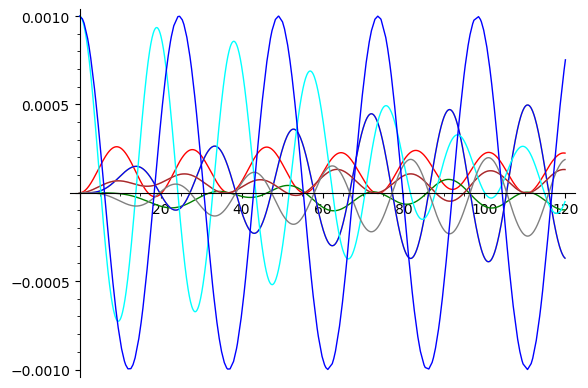

In [136]:
M = 1200
p = Graphics()
for i in range(model.atom_count):
    p += line(zip(times, sol0[0:M,2*i+1]), color=colors[i])
#p.show(title="$Exact y_i(t)$")


sol_omega_i = sol_omega[6]
p += plot(0.001*(cos(omega*t)).subs(sol_omega_i.subs(values)), t, 0, 120)
p.show()

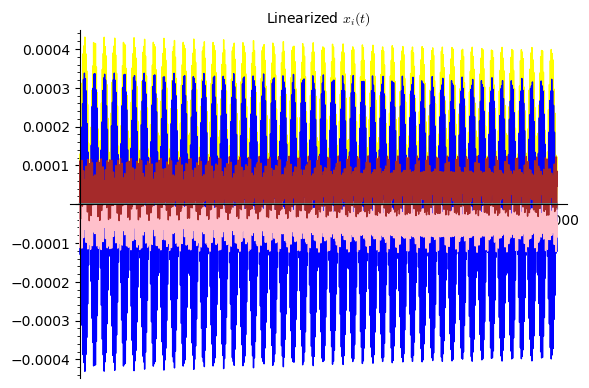

In [79]:
p = Graphics()
for i in range(model.atom_count):
    p += line(zip(times, sol2[:,2*i]), color=colors[i])
p.show(title="Linearized $x_i(t)$")

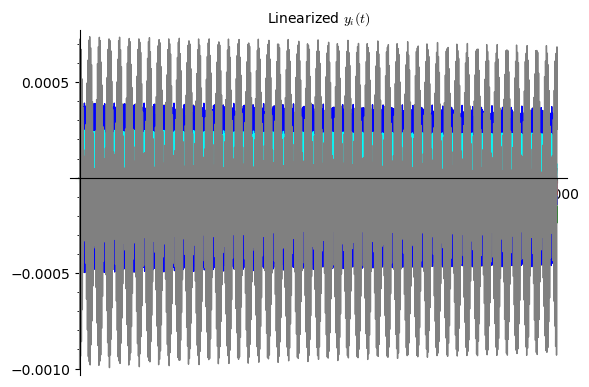

In [80]:
p = Graphics()
for i in range(model.atom_count):
    p += line(zip(times, sol2[:,2*i+1]), color=colors[i])
p.show(title="Linearized $y_i(t)$")

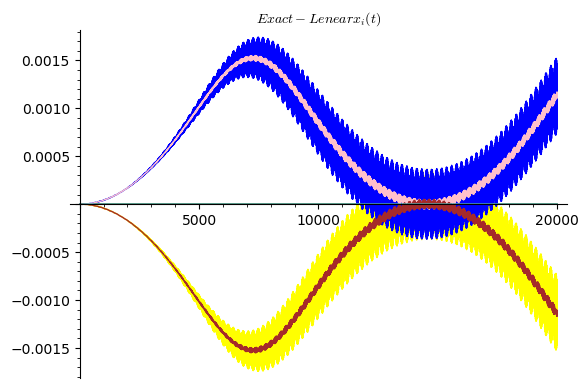

In [90]:
p = Graphics()
for i in range(model.atom_count):
    p += line(zip(times, sol0[:,2*i]-sol2[:,2*i]), color=colors[i])
p.show(title="$Exact-Linear x_i(t)$")

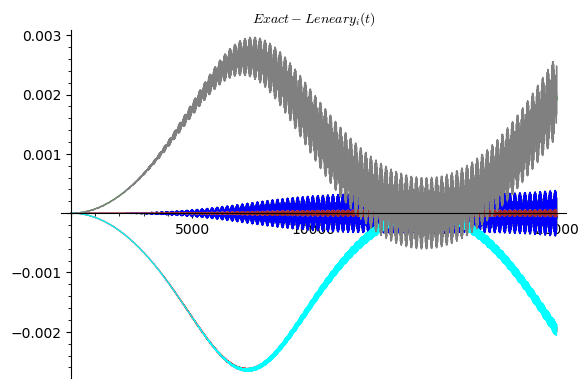

In [91]:
p = Graphics()
for i in range(model.atom_count):
    p += line(zip(times, sol0[:,2*i+1]-sol2[:,2*i+1]), color=colors[i])
p.show(title="$Exact-Linear y_i(t)$")

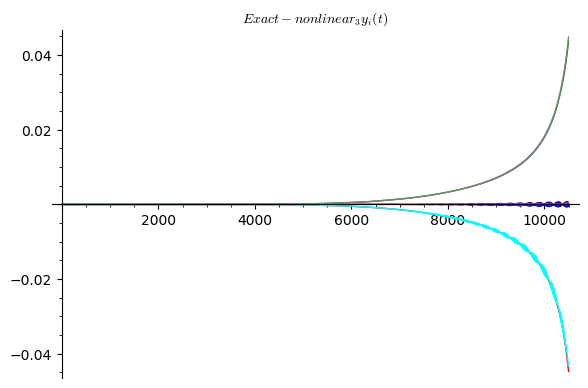

In [174]:
M = 1050000

p = Graphics()
for i in range(model.atom_count):
    p += line(zip(times,sol0[0:M,2*i+1]-sol3[0:M,2*i+1]), color=colors[i])
p.show(title="$Exact - nonlinear_3 y_i(t)$")

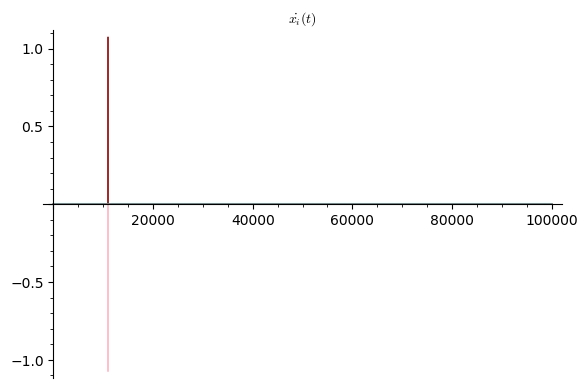

In [63]:
p = Graphics()
for i in range(model.atom_count):
    p += line(zip(times,sol3[:,2*i+2*model.atom_count]-sol2[:,2*i+2*model.atom_count]), color=colors[i])
p.show(title="$\\dot{x_i}(t)$")

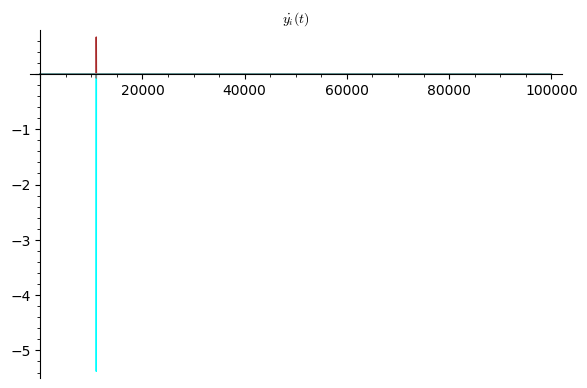

In [64]:
p = Graphics()
for i in range(model.atom_count):
    p += line(zip(times,sol3[:,2*i+1+2*model.atom_count]-sol2[:,2*i+1+2*model.atom_count]), color=colors[i])
p.show(title="$\\dot{y_i}(t)$")

Animation with 1000 frames
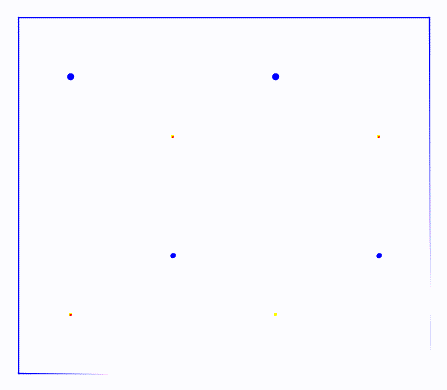

In [65]:
model.animate_sol(times, sol0, 1000)

Animation with 1000 frames
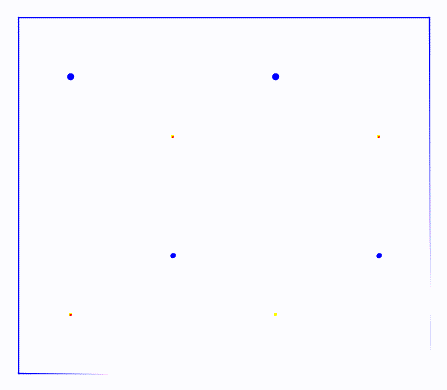

In [66]:
model.animate_sol(times, sol2, 1000)

Animation with 1000 frames
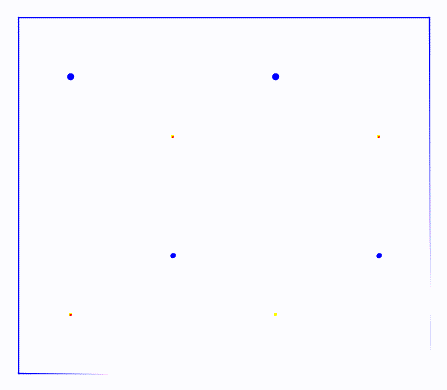

In [67]:
model.animate_sol(times, sol3, 1000)

We have the following linearized Euler Lagrange equations:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Using exponent-like solutions we have the following algebraic system:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Matrix of this system is:


<IPython.core.display.Math object>

determinant is:


<IPython.core.display.Math object>

we have solution when the determinant is 0


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

using the following found frequency


<IPython.core.display.Math object>

we have the following system for amplitude coefficients


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

with determinant:


<IPython.core.display.Math object>

rank of this system is:


<IPython.core.display.Math object>

so I can eleminate 8  -  7  =  1 equations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

And the solution for frequency omega == -sqrt(3/2*k/M + 3/2*k/m + 1/2*sqrt(3*M^2 - 2*M*m + 3*m^2)*k/(M*m)) is:


<IPython.core.display.Math object>

assuming that r1 is  0.100000000000000  we have:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

and the mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

assumed r1=0.100000000000000 mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

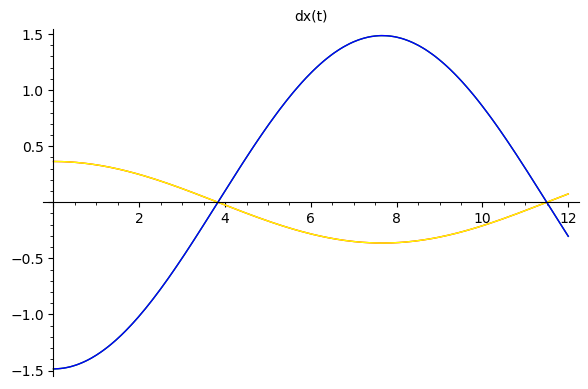

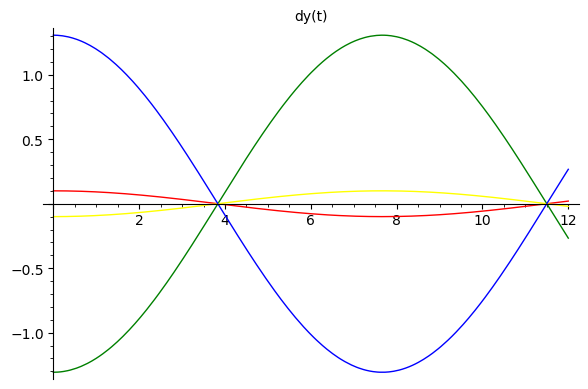

Animation with 120 frames
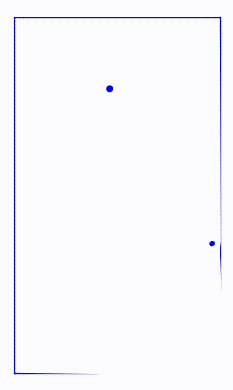

using the following found frequency


<IPython.core.display.Math object>

we have the following system for amplitude coefficients


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

with determinant:


<IPython.core.display.Math object>

rank of this system is:


<IPython.core.display.Math object>

so I can eleminate 8  -  7  =  1 equations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

And the solution for frequency omega == sqrt(3/2*k/M + 3/2*k/m + 1/2*sqrt(3*M^2 - 2*M*m + 3*m^2)*k/(M*m)) is:


<IPython.core.display.Math object>

assuming that r2 is  0.100000000000000  we have:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

and the mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

assumed r2=0.100000000000000 mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

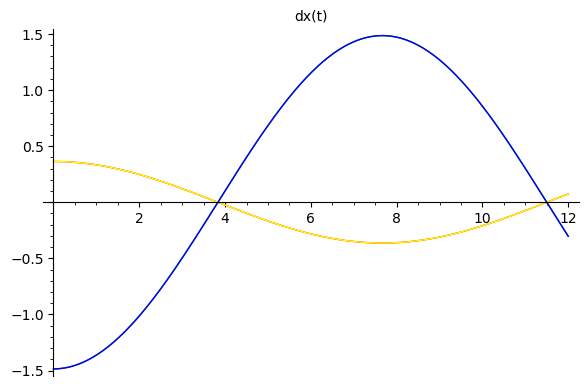

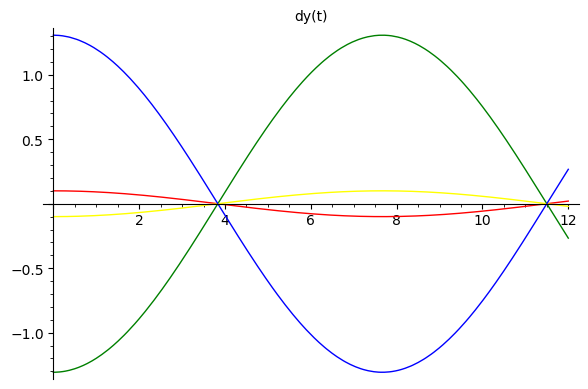

Animation with 120 frames
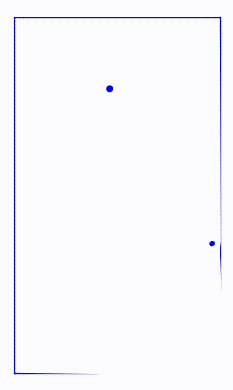

using the following found frequency


<IPython.core.display.Math object>

we have the following system for amplitude coefficients


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

with determinant:


<IPython.core.display.Math object>

rank of this system is:


<IPython.core.display.Math object>

so I can eleminate 8  -  7  =  1 equations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

And the solution for frequency omega == -sqrt(3/2*k/M + 3/2*k/m - 1/2*sqrt(3*M^2 - 2*M*m + 3*m^2)*k/(M*m)) is:


<IPython.core.display.Math object>

assuming that r3 is  0.100000000000000  we have:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

and the mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

assumed r3=0.100000000000000 mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

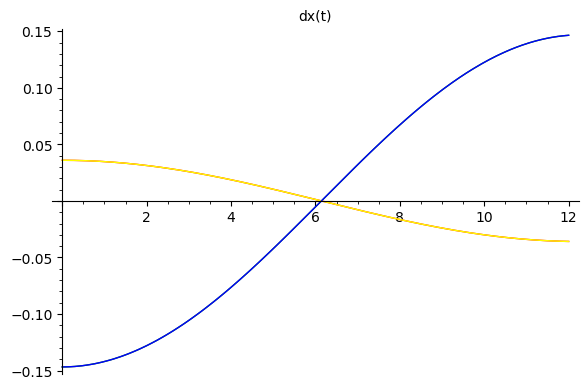

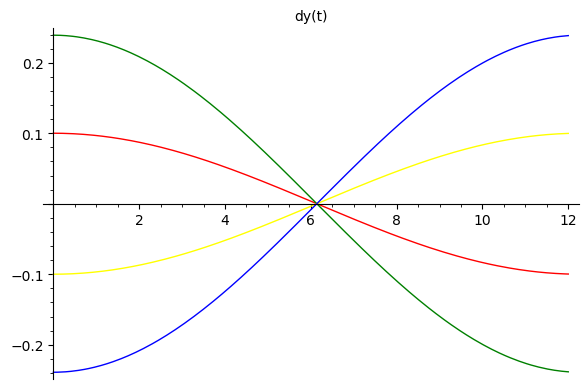

Animation with 120 frames
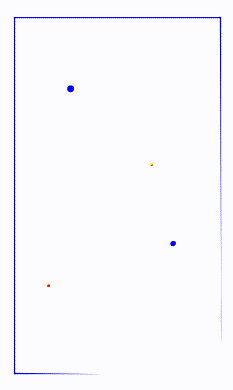

using the following found frequency


<IPython.core.display.Math object>

we have the following system for amplitude coefficients


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

with determinant:


<IPython.core.display.Math object>

rank of this system is:


<IPython.core.display.Math object>

so I can eleminate 8  -  7  =  1 equations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

And the solution for frequency omega == sqrt(3/2*k/M + 3/2*k/m - 1/2*sqrt(3*M^2 - 2*M*m + 3*m^2)*k/(M*m)) is:


<IPython.core.display.Math object>

assuming that r4 is  0.100000000000000  we have:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

and the mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

assumed r4=0.100000000000000 mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

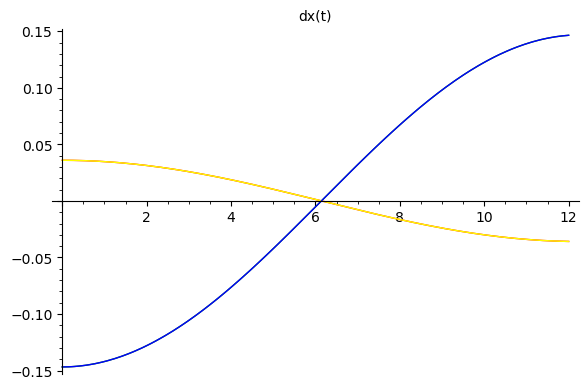

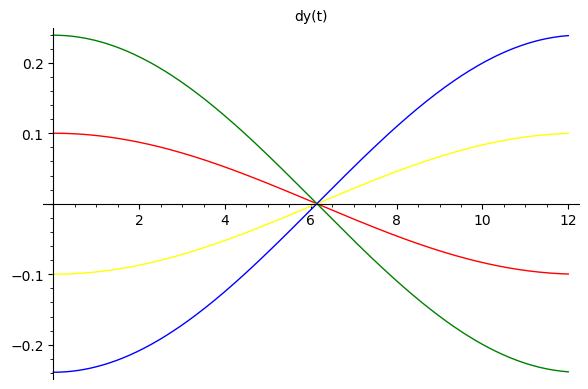

Animation with 120 frames
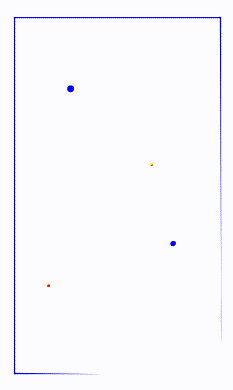

using the following found frequency


<IPython.core.display.Math object>

we have the following system for amplitude coefficients


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

with determinant:


<IPython.core.display.Math object>

rank of this system is:


<IPython.core.display.Math object>

so I can eleminate 8  -  7  =  1 equations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

And the solution for frequency omega == -sqrt(1/2*sqrt(3)*k/M + 1/2*sqrt(3)*k/m + 3/2*k/M + 3/2*k/m) is:


<IPython.core.display.Math object>

assuming that r5 is  0.100000000000000  we have:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

and the mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

assumed r5=0.100000000000000 mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

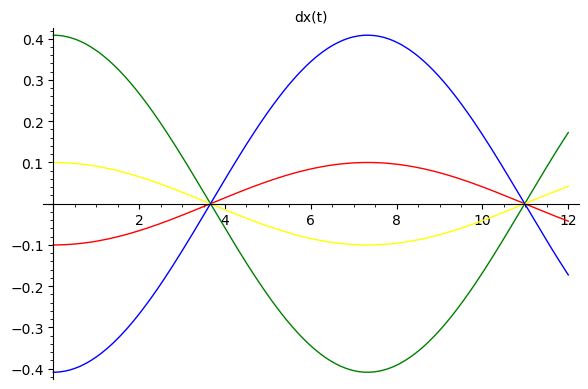

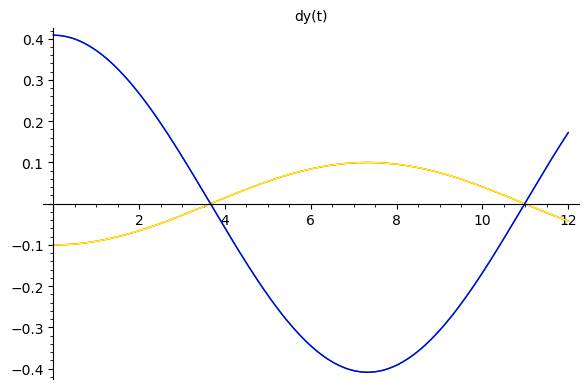

Animation with 120 frames
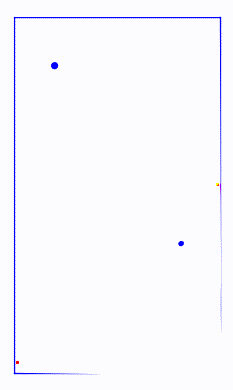

using the following found frequency


<IPython.core.display.Math object>

we have the following system for amplitude coefficients


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

with determinant:


<IPython.core.display.Math object>

rank of this system is:


<IPython.core.display.Math object>

so I can eleminate 8  -  7  =  1 equations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

And the solution for frequency omega == sqrt(1/2*sqrt(3)*k/M + 1/2*sqrt(3)*k/m + 3/2*k/M + 3/2*k/m) is:


<IPython.core.display.Math object>

assuming that r6 is  0.100000000000000  we have:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

and the mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

assumed r6=0.100000000000000 mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

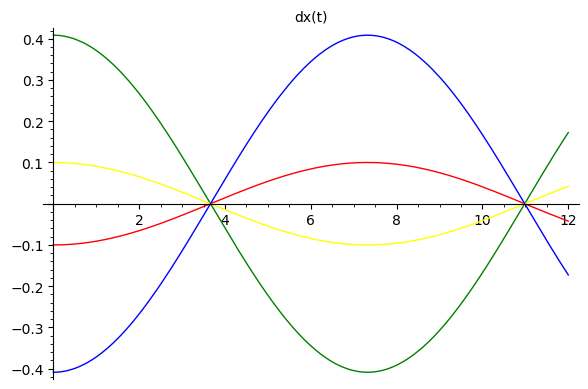

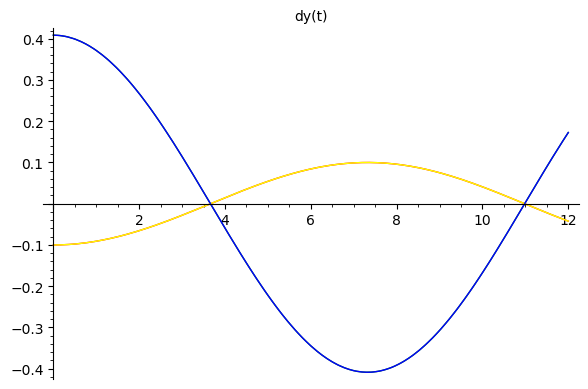

Animation with 120 frames
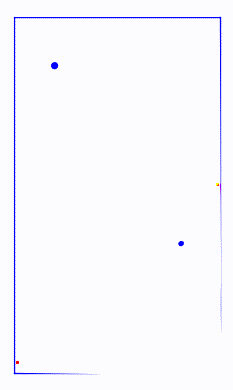

using the following found frequency


<IPython.core.display.Math object>

we have the following system for amplitude coefficients


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

with determinant:


<IPython.core.display.Math object>

rank of this system is:


<IPython.core.display.Math object>

so I can eleminate 8  -  7  =  1 equations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

And the solution for frequency omega == -sqrt(-1/2*sqrt(3)*k/M - 1/2*sqrt(3)*k/m + 3/2*k/M + 3/2*k/m) is:


<IPython.core.display.Math object>

assuming that r7 is  0.100000000000000  we have:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

and the mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

assumed r7=0.100000000000000 mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

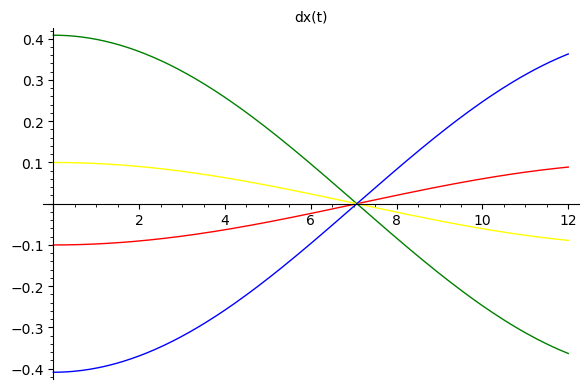

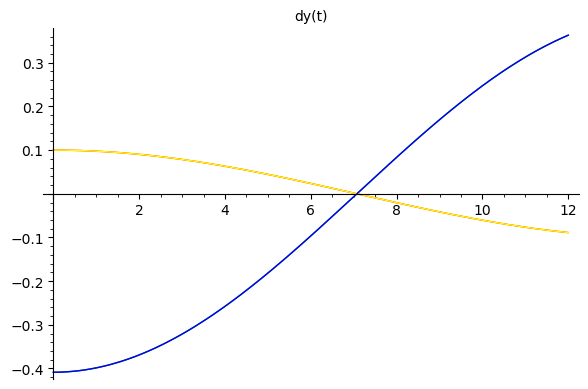

Animation with 120 frames
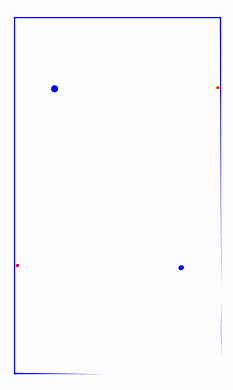

using the following found frequency


<IPython.core.display.Math object>

we have the following system for amplitude coefficients


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

with determinant:


<IPython.core.display.Math object>

rank of this system is:


<IPython.core.display.Math object>

so I can eleminate 8  -  7  =  1 equations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

And the solution for frequency omega == sqrt(-1/2*sqrt(3)*k/M - 1/2*sqrt(3)*k/m + 3/2*k/M + 3/2*k/m) is:


<IPython.core.display.Math object>

assuming that r8 is  0.100000000000000  we have:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

and the mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

assumed r8=0.100000000000000 mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

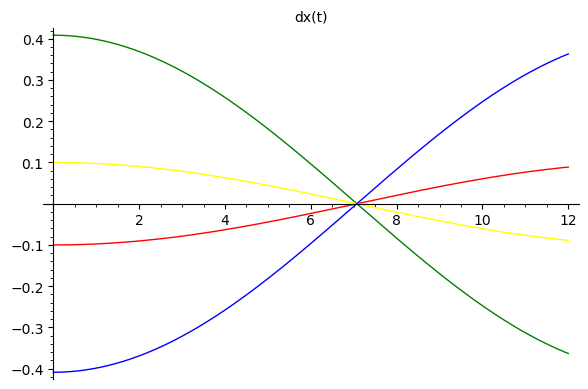

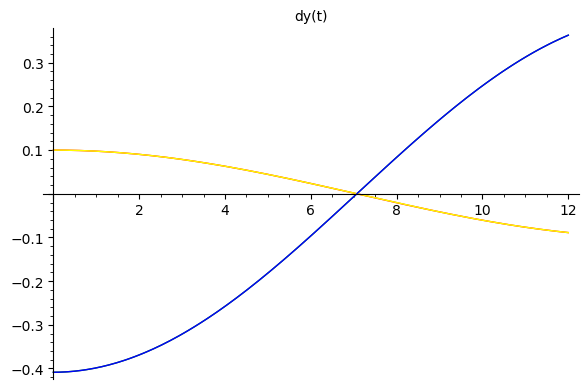

Animation with 120 frames
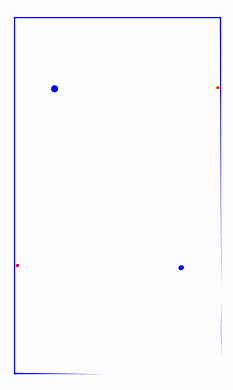

using the following found frequency


<IPython.core.display.Math object>

we have the following system for amplitude coefficients


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

with determinant:


<IPython.core.display.Math object>

rank of this system is:


<IPython.core.display.Math object>

so I can eleminate 8  -  4  =  4 equations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

And the solution for frequency omega == 0 is:


<IPython.core.display.Math object>

assuming that r11 is  0.100000000000000  we have:
assuming that r12 is  0.100000000000000  we have:
assuming that r14 is  0.100000000000000  we have:
assuming that r10 is  0.100000000000000  we have:
assuming that r13 is  0.100000000000000  we have:
assuming that r9 is  0.100000000000000  we have:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

and the mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

assumed r11=0.100000000000000 r12=0.100000000000000 r14=0.100000000000000 r10=0.100000000000000 r13=0.100000000000000 r9=0.100000000000000 mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

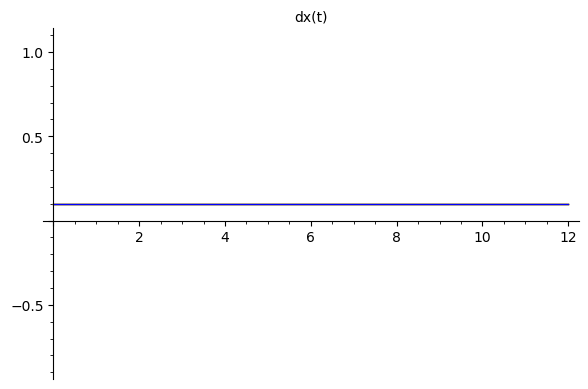

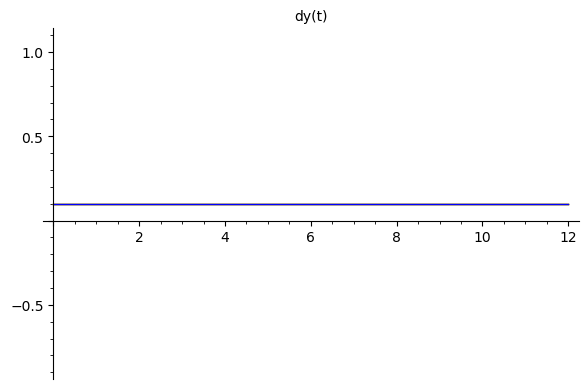

Animation with 120 frames
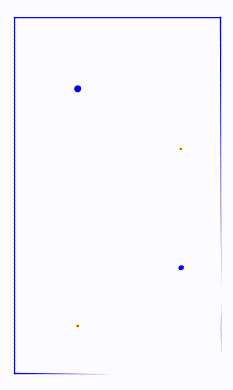

In [68]:
mode_motions, assumed_mode_motions = model4.EulerLagrangeMatrix()

In [69]:
# linear
# система уравнений Эйлера-Лагранжа
eqs_x, eqs_y = model.EulerLagrange(n = 2)
print("linear Euler Lagrange equation's part")
#disp(eqs_x + eqs_y)
for i in range(model.atom_count):
    linear_eq_x = (eqs_x)[i]
    linear_eq_y = (eqs_y)[i]
    print("linear_eq_x", i)
    disp(linear_eq_x)
    print("linear_eq_y", i)
    disp(linear_eq_y)

# nonlinear part of potential energy
nonlinear_part_of_U = model.PotentialEnergyTaylor(n = 3)[2:][0]

print("nonlinear Euler Lagrange equation's part")
# nonlinear система уравнений Эйлера-Лагранжа
nonlinear_dUdx = []
nonlinear_dUdy = []

for i in range(model.atom_count):
    nonlinear_dUdx += [ nonlinear_part_of_U \
                        .subs(model.dx[i] == model.DX[i]) \
                        .diff(model.DX[i]) \
                        .subs(model.DX[i] == model.dx[i]) ]
    nonlinear_dUdy += [ nonlinear_part_of_U \
                        .subs(model.dy[i] == model.DY[i]) \
                        .diff(model.DY[i]) \
                        .subs(model.DY[i] == model.dy[i]) ]

    print("nonlinear dUdx", i)
    disp(nonlinear_dUdx[i])
    print("nonlinear dUdy", i)
    disp(nonlinear_dUdy[i])

# решение системы уравнений Эйлера-Лагранжа
# ищем в виде

# нулевое приближение удобнее выбрать
# в виде exp от I*omega_0*t
# с неким сдвигом фаз phi
# и со сдвигом частоты omega_1

xi = []
yi = []

for i in range(model.atom_count):
    # e^(i*omega*t)
    xi += [model.Ax[i]*exp(I*omega*t)]
    yi += [model.Ay[i]*exp(I*omega*t)]

# подставляя решения в систему
# уравнений Эйлера Лагранжа
# получаем систему линейных алгебраичных уравнений

# метод последовательных приближений
# вводим добавку x1 к нулевому приближению решения,
# и подставляем это решение
# с добавкой лишь к линейной части дифференциального уравнения
# но в нелинейной части пока что пренебегаем добавкой x1
# предположив малость величины добавки x1 по сравнению с x0

print("method of successive approximations")

eqsi_x1 = []
eqsi_y1 = []
for i in range(model.atom_count):
    eqx_i = eqs_x[i].substitute_function(model.dx[i] == xi[i] + model.x1[i]).lhs() \
          - nonlinear_dUdx[i].substitute_function(model.dx[i] == xi[i])
    eqy_i = eqs_y[i].substitute_function(model.dy[i] == yi[i] + model.y1[i]).lhs() \
          - nonlinear_dUdy[i].substitute_function(model.dy[i] == yi[i])
    for j in range(model.atom_count):
        eqx_i = eqx_i.subs(model.dx[j] == xi[j] + model.x1[i])
        eqx_i = eqx_i.subs(model.dy[j] == yi[j] + model.y1[i])

        eqy_i = eqy_i.subs(model.dx[j] == xi[j] + model.x1[i])
        eqy_i = eqy_i.subs(model.dy[j] == yi[j] + model.y1[i])

    eqx_i = eqx_i.expand().collect(model.x1[i])
    eqy_i = eqy_i.expand().collect(model.y1[i])

    print("eqx_i",i)
    disp(eqx_i)
    print("eqy_i",i)
    disp(eqy_i)

    print("coefficient on", model.x1[i])
    x1_coeff_t = eqx_i.coefficient(model.x1[i])
    disp(x1_coeff_t)

    x1_coeff = (x1_coeff_t / exp(I*omega*t)).expand()
    disp(x1_coeff)

    C_x1 = var("C_x1")

    print("coefficient on", model.x1[i].diff(t))
    dx1dt_coeff = eqx_i.coefficient(model.x1[i].diff(t))
    disp(dx1dt_coeff)

    print("coefficient on", model.x1[i].diff(t, 2))
    d2x1dt2_coeff = eqx_i.coefficient(model.x1[i].diff(t, 2))
    disp(d2x1dt2_coeff)

    print("coefficient on", model.x1[i]^2)
    x1_2_coeff = eqx_i.coefficient(model.x1[i]^2)
    disp(x1_2_coeff)

    # однородная часть дифференциального уравнения
    uniform_x = d2x1dt2_coeff * model.x1[i].diff(t, 2) + \
                dx1dt_coeff * model.x1[i].diff(t) + \
                x1_coeff * model.x1[i] * exp(I*omega*t)

    uniform_Cx = d2x1dt2_coeff * model.x1[i].diff(t, 2) + \
                dx1dt_coeff * model.x1[i].diff(t) + \
                C_x1 * model.x1[i] * exp(I*omega*t)

    # слагаемые типа "вынуждающей силы"
    f_x = (eqx_i - uniform_x - x1_2_coeff * model.x1[i]^2).expand()
    print("f_x")
    disp(f_x)

    # отбрасываем слагаемое с model.x1[i]^2 имеющее больший порядок малости
    other_x = eqx_i - x1_2_coeff * model.x1[i]^2

    print("coefficient on", model.y1[i])
    y1_coeff_t = eqy_i.coefficient(model.y1[i])
    disp(y1_coeff_t)

    y1_coeff = (y1_coeff_t / exp(I*omega*t)).expand()
    disp(y1_coeff)

    C_y1 = var("C_y1")

    print("coefficient on", model.y1[i].diff(t))
    dy1dt_coeff = eqy_i.coefficient(model.y1[i].diff(t))
    disp(dy1dt_coeff)

    print("coefficient on", model.y1[i].diff(t, 2))
    d2y1dt2_coeff = eqy_i.coefficient(model.y1[i].diff(t, 2))
    disp(d2y1dt2_coeff)

    print("coefficient on", model.y1[i]^2)
    y1_2_coeff = eqy_i.coefficient(model.y1[i]^2)
    disp(y1_2_coeff)

    # однородная часть дифференциального уравнения
    uniform_y = d2y1dt2_coeff * model.y1[i].diff(t, 2) + \
                dy1dt_coeff * model.y1[i].diff(t) + \
                y1_coeff * model.y1[i] * exp(I*omega*t)

    uniform_Cy = d2y1dt2_coeff * model.y1[i].diff(t, 2) + \
                dy1dt_coeff * model.y1[i].diff(t) + \
                C_y1 * model.y1[i] * exp(I*omega*t)

    # слагаемые типа "вынуждающей силы"
    f_y = (eqy_i - uniform_y - y1_2_coeff * model.y1[i]^2).expand()
    print("f_y")
    disp(f_y)

    # отбрасываем слагаемое с model.x1[i]^2 имеющее больший порядок малости
    other_y = eqy_i - y1_2_coeff * model.y1[i]^2

    eqsi_x1 += [ other_x == 0]
    eqsi_y1 += [ other_y == 0]    

    print("eqsi_x1[", i, "]")
    disp(eqsi_x1[i])
    print("eqsi_y1[", i, "]")
    disp(eqsi_y1[i])

    # решаем однородное дифференциальное уравнение относительно x1
    #print("uniform solve with x1")
    #disp(uniform_Cx == 0)
    #uniform_sol_x1 = desolve(uniform_Cx == 0, model.x1[i], ivar=t, algorithm="fricas")
    #print(uniform_sol_x1)

    # решаем однородное дифференциальное уравнение относительно y1
    #print("uniform solve with y1")
    #disp(uniform_Cy == 0)
    #uniform_sol_y1 = desolve(uniform_Cy == 0, model.y1[i], ivar=t, contrib_ode = True)
    #print(uniform_sol_y1)

    # решаем это дифференциальное уравнение относительно x1
    #print("solve with x1")
    #disp(eqsi_x[i])
    #sol_x1 = desolve(eqsi_x[i], model.x1[i], ivar=t, contrib_ode = True)
    #print(sol_x1)

    # решаем это дифференциальное уравнение относительно y1
    #print("solve with y1")
    #disp(eqsi_y[i])
    #sol_y1 = desolve(eqsi_y[i], model.y1[i], ivar=t, contrib_ode = True)
    #print(sol_y1)


linear Euler Lagrange equation's part
linear_eq_x 0


<IPython.core.display.Math object>

linear_eq_y 0


<IPython.core.display.Math object>

linear_eq_x 1


<IPython.core.display.Math object>

linear_eq_y 1


<IPython.core.display.Math object>

linear_eq_x 2


<IPython.core.display.Math object>

linear_eq_y 2


<IPython.core.display.Math object>

linear_eq_x 3


<IPython.core.display.Math object>

linear_eq_y 3


<IPython.core.display.Math object>

linear_eq_x 4


<IPython.core.display.Math object>

linear_eq_y 4


<IPython.core.display.Math object>

linear_eq_x 5


<IPython.core.display.Math object>

linear_eq_y 5


<IPython.core.display.Math object>

linear_eq_x 6


<IPython.core.display.Math object>

linear_eq_y 6


<IPython.core.display.Math object>

linear_eq_x 7


<IPython.core.display.Math object>

linear_eq_y 7


<IPython.core.display.Math object>

nonlinear Euler Lagrange equation's part
nonlinear dUdx 0


<IPython.core.display.Math object>

nonlinear dUdy 0


<IPython.core.display.Math object>

nonlinear dUdx 1


<IPython.core.display.Math object>

nonlinear dUdy 1


<IPython.core.display.Math object>

nonlinear dUdx 2


<IPython.core.display.Math object>

nonlinear dUdy 2


<IPython.core.display.Math object>

nonlinear dUdx 3


<IPython.core.display.Math object>

nonlinear dUdy 3


<IPython.core.display.Math object>

nonlinear dUdx 4


<IPython.core.display.Math object>

nonlinear dUdy 4


<IPython.core.display.Math object>

nonlinear dUdx 5


<IPython.core.display.Math object>

nonlinear dUdy 5


<IPython.core.display.Math object>

nonlinear dUdx 6


<IPython.core.display.Math object>

nonlinear dUdy 6


<IPython.core.display.Math object>

nonlinear dUdx 7


<IPython.core.display.Math object>

nonlinear dUdy 7


<IPython.core.display.Math object>

method of successive approximations
eqx_i 0


<IPython.core.display.Math object>

eqy_i 0


<IPython.core.display.Math object>

coefficient on x1_0(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(x1_0(t), t)


<IPython.core.display.Math object>

coefficient on diff(x1_0(t), t, t)


<IPython.core.display.Math object>

coefficient on x1_0(t)^2


<IPython.core.display.Math object>

f_x


<IPython.core.display.Math object>

coefficient on y1_0(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(y1_0(t), t)


<IPython.core.display.Math object>

coefficient on diff(y1_0(t), t, t)


<IPython.core.display.Math object>

coefficient on y1_0(t)^2


<IPython.core.display.Math object>

f_y


<IPython.core.display.Math object>

eqsi_x1[ 0 ]


<IPython.core.display.Math object>

eqsi_y1[ 0 ]


<IPython.core.display.Math object>

eqx_i 1


<IPython.core.display.Math object>

eqy_i 1


<IPython.core.display.Math object>

coefficient on x1_1(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(x1_1(t), t)


<IPython.core.display.Math object>

coefficient on diff(x1_1(t), t, t)


<IPython.core.display.Math object>

coefficient on x1_1(t)^2


<IPython.core.display.Math object>

f_x


<IPython.core.display.Math object>

coefficient on y1_1(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(y1_1(t), t)


<IPython.core.display.Math object>

coefficient on diff(y1_1(t), t, t)


<IPython.core.display.Math object>

coefficient on y1_1(t)^2


<IPython.core.display.Math object>

f_y


<IPython.core.display.Math object>

eqsi_x1[ 1 ]


<IPython.core.display.Math object>

eqsi_y1[ 1 ]


<IPython.core.display.Math object>

eqx_i 2


<IPython.core.display.Math object>

eqy_i 2


<IPython.core.display.Math object>

coefficient on x1_2(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(x1_2(t), t)


<IPython.core.display.Math object>

coefficient on diff(x1_2(t), t, t)


<IPython.core.display.Math object>

coefficient on x1_2(t)^2


<IPython.core.display.Math object>

f_x


<IPython.core.display.Math object>

coefficient on y1_2(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(y1_2(t), t)


<IPython.core.display.Math object>

coefficient on diff(y1_2(t), t, t)


<IPython.core.display.Math object>

coefficient on y1_2(t)^2


<IPython.core.display.Math object>

f_y


<IPython.core.display.Math object>

eqsi_x1[ 2 ]


<IPython.core.display.Math object>

eqsi_y1[ 2 ]


<IPython.core.display.Math object>

eqx_i 3


<IPython.core.display.Math object>

eqy_i 3


<IPython.core.display.Math object>

coefficient on x1_3(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(x1_3(t), t)


<IPython.core.display.Math object>

coefficient on diff(x1_3(t), t, t)


<IPython.core.display.Math object>

coefficient on x1_3(t)^2


<IPython.core.display.Math object>

f_x


<IPython.core.display.Math object>

coefficient on y1_3(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(y1_3(t), t)


<IPython.core.display.Math object>

coefficient on diff(y1_3(t), t, t)


<IPython.core.display.Math object>

coefficient on y1_3(t)^2


<IPython.core.display.Math object>

f_y


<IPython.core.display.Math object>

eqsi_x1[ 3 ]


<IPython.core.display.Math object>

eqsi_y1[ 3 ]


<IPython.core.display.Math object>

eqx_i 4


<IPython.core.display.Math object>

eqy_i 4


<IPython.core.display.Math object>

coefficient on x1_4(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(x1_4(t), t)


<IPython.core.display.Math object>

coefficient on diff(x1_4(t), t, t)


<IPython.core.display.Math object>

coefficient on x1_4(t)^2


<IPython.core.display.Math object>

f_x


<IPython.core.display.Math object>

coefficient on y1_4(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(y1_4(t), t)


<IPython.core.display.Math object>

coefficient on diff(y1_4(t), t, t)


<IPython.core.display.Math object>

coefficient on y1_4(t)^2


<IPython.core.display.Math object>

f_y


<IPython.core.display.Math object>

eqsi_x1[ 4 ]


<IPython.core.display.Math object>

eqsi_y1[ 4 ]


<IPython.core.display.Math object>

eqx_i 5


<IPython.core.display.Math object>

eqy_i 5


<IPython.core.display.Math object>

coefficient on x1_5(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(x1_5(t), t)


<IPython.core.display.Math object>

coefficient on diff(x1_5(t), t, t)


<IPython.core.display.Math object>

coefficient on x1_5(t)^2


<IPython.core.display.Math object>

f_x


<IPython.core.display.Math object>

coefficient on y1_5(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(y1_5(t), t)


<IPython.core.display.Math object>

coefficient on diff(y1_5(t), t, t)


<IPython.core.display.Math object>

coefficient on y1_5(t)^2


<IPython.core.display.Math object>

f_y


<IPython.core.display.Math object>

eqsi_x1[ 5 ]


<IPython.core.display.Math object>

eqsi_y1[ 5 ]


<IPython.core.display.Math object>

eqx_i 6


<IPython.core.display.Math object>

eqy_i 6


<IPython.core.display.Math object>

coefficient on x1_6(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(x1_6(t), t)


<IPython.core.display.Math object>

coefficient on diff(x1_6(t), t, t)


<IPython.core.display.Math object>

coefficient on x1_6(t)^2


<IPython.core.display.Math object>

f_x


<IPython.core.display.Math object>

coefficient on y1_6(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(y1_6(t), t)


<IPython.core.display.Math object>

coefficient on diff(y1_6(t), t, t)


<IPython.core.display.Math object>

coefficient on y1_6(t)^2


<IPython.core.display.Math object>

f_y


<IPython.core.display.Math object>

eqsi_x1[ 6 ]


<IPython.core.display.Math object>

eqsi_y1[ 6 ]


<IPython.core.display.Math object>

eqx_i 7


<IPython.core.display.Math object>

eqy_i 7


<IPython.core.display.Math object>

coefficient on x1_7(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(x1_7(t), t)


<IPython.core.display.Math object>

coefficient on diff(x1_7(t), t, t)


<IPython.core.display.Math object>

coefficient on x1_7(t)^2


<IPython.core.display.Math object>

f_x


<IPython.core.display.Math object>

coefficient on y1_7(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(y1_7(t), t)


<IPython.core.display.Math object>

coefficient on diff(y1_7(t), t, t)


<IPython.core.display.Math object>

coefficient on y1_7(t)^2


<IPython.core.display.Math object>

f_y


<IPython.core.display.Math object>

eqsi_x1[ 7 ]


<IPython.core.display.Math object>

eqsi_y1[ 7 ]


<IPython.core.display.Math object>

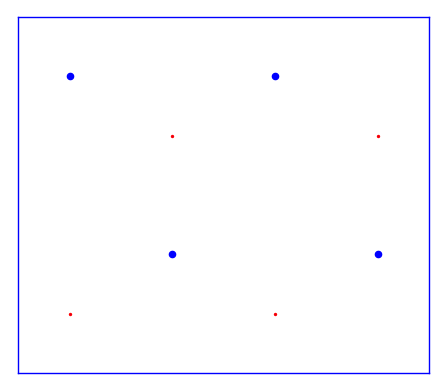

In [70]:
p = model.plot()
model.show(p)

In [ ]:
for i in range(model.atom_count):
    print(i, model.crd0[i])

In [ ]:
for i in range(model.atom_count):
    print(i, model.nbr[i])

In [ ]:
for i in range(model.atom_count):
    print(i, model.nbr[i])
    for nb in model.nbr[i]:
        print(nb, model.nbr2index(nb))

In [ ]:
model.test_dUdX(2)

In [ ]:
disp(model.w[2])

In [ ]:
dw2dy2 = model.w[2].diff(model.DY[2])
disp(dw2dy2)

In [ ]:
for i in range(model.atom_count):
    model.test_UX(i)

In [ ]:
for i in range(model.atom_count):
    model.test_UY(i)

In [ ]:
model.test_UX(0)

In [ ]:
model.test_UY(0)

In [ ]:
model.test_dUdY(0)

In [ ]:
disp(model.w[0])